# World Data League 2022

## 🎯 Challenge
*Predict Waste Production for its Reduction*


## 👥 Authors
* David Gamba
* Melissa Montes
* Juan Diego Arango
* Irune Lansorena
* Santiago Cardona

## 💻 Development

### Table of contents
- Libraries

0. Data and preprocessing
1. Inidial Exploratory Data Analysis (EDA)
2. Trend forecast
3. Cluster construction
4. Cluster and forecast analysis
5. Conclusions and final remarks

### Libraries

We install additional libraries used in the project

In [1]:
!pip install -q -U altair_data_server fbprophet geopandas

In [2]:
import altair as alt
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import warnings
import datetime
import os
import matplotlib


from tqdm import tqdm
from toolz.functoolz import compose

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics, cross_validation
from fbprophet.plot import plot

from google.colab import drive

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from typing import List

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Connection to Google Drive folder
# from google.colab import drive
# drive.mount('/content/drive')

#Cloud storage
path = "https://storage.googleapis.com/geoneas-bucket/waste-s1/data/"

In [4]:
matplotlib.rcParams['figure.figsize'] = (8, 5)

### 0. Data and preprocessing

This process could be checked in [data_acquisition notebook](https://dagshub.com/astenuz/geoneas-wdl/src/master/waste-s1/notebooks/data_acquisition.ipynb) and allows to obtain data in the correct format to conduct the exploratory data analysis and model construction.

First, we loaded census tracts polygons in order to intersect with garbage and recycling polygon routes. We obtained how much waste and recycling was collected per census tract in Austin. Census tracts will be the baseline for our next analysis. 

Secondly, we connect the waste data with census tracts. This allows to analyse the complete time series information, especially to built the model per census tract.

Thirdly, we create a socioeconomic and vulnerability databases to create clusters in Austin with similar characteristics.

Fourth, we create a census tract polygon shapefile as the base for geographic representations.

For the clusters formation, we developed [another preprocessing notebook](https://dagshub.com/astenuz/geoneas-wdl/waste-s1/notebooks/data_agg_tract.ipynb). This one is shorter and just cleans and joins socioeconomic and vulnerability data.

### 1. Exploratory Data Analysis (EDA)

In this part we are going to conduct the exploratory data analysis of waste production. Previously, we conducted the data acquisition notebook (available as appendix) where garbage and recycling data per polygon route were added to the census tracts of Austin. We decided to analyse to this geographic level because this allows to later merge with socioeconomic information.

**Objective**

Our objective in this notebook is to determine whether trends appear while looking at waste at the census tract level, and whether it makes sense to forecast these trends.

**Context**

It is important to give information of the waste management at the level of Austin's poltical subdivisions (know here as Tract) as these subdivision are related to the socio-economic features. By narrowing the waste information into this regions, it is possible to relate the nature of the waste management in time with the socio-economic variables.

To find the behavior of waste at the level of a Tract, the two relevant sources of information are the political subdivision of Austin and the amount of different kinds of waste collected at different parts of the city at different points in time. Part of the objective of the data acquisition notebook is to assign to each political subdivision a loads of waste in time. This loads of waste encompass recycling material and garbage.

The amount of waste collected in different parts of the city is at https://data.austintexas.gov/. The web page gives, for each type of waste recollection, a different partition of Austin into regions. Each region has an associated dataframe with the amount of waste collected at a date.

At the same time, the subdivision of the city of Austin into political subregions (Tracts) is at https://austin-energy.data.socrata.com.

The data acquisition notebook superimposes the regions associated with the data collection and the Tracts. Each Tract that is partially or totally inside a waste collection regions will be assign a load of waste proportional to its share of the total area of the waste collection region. This processes is done for each kind of waste and for each date recorded. The result is that each Tract gets it individual set of different waste load in time. 

This information is at tract_loads.parquet.




#### 1.1. Data Preparation

In this sub-section we upload the database and conduct some preparation to do EDA for waste production per tract

First we load the data that aggregates daily load per type.

In [5]:
waste = pd.read_csv('https://data.austintexas.gov/api/views/mbnu-4wq9/rows.csv?accessType=DOWNLOAD')
tract_load = pd.read_parquet(path + 'tract_loads.parquet')
tract_load.sample(3)

,index,fips,load_type,load_date,tract_load
307278,53250,48453001781,RECYCLING - SINGLE STREAM,2021-05-19,23742.165176
327142,73114,48453001856,RECYCLING - SINGLE STREAM,2013-01-04,250.652839
58973,58973,48453001706,GARBAGE COLLECTIONS,2017-03-01,171.023141


Firstly, we are going to group the data using Fips and load type as reference. Fips are the identifier to each census tracts.

In [6]:
tract_load = tract_load.groupby([
    'fips', 
    'load_type', 
    pd.Grouper(key='load_date',freq='M')]).agg({'tract_load': 'sum'}).reset_index()
tract_load.head()

,fips,load_type,load_date,tract_load
0,48209010901,GARBAGE COLLECTIONS,2004-02-29,3904.784900
1,48209010901,GARBAGE COLLECTIONS,2004-10-31,57129.508306
2,48209010901,GARBAGE COLLECTIONS,2004-11-30,53988.424876
3,48209010901,GARBAGE COLLECTIONS,2004-12-31,46565.096276
4,48209010901,GARBAGE COLLECTIONS,2005-01-31,52168.660225


How many tracts could be associated with the routes?

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of months with data for each fips')]

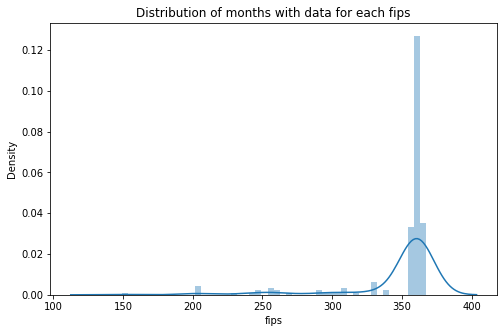

In [7]:
sns.distplot(tract_load.fips.value_counts()).set(title="Distribution of months with data for each fips")

On the other hand, even when the routes we mapped to tracts are categorized as garbage and recycling routes, there are more granularities of load type.

In [8]:
tract_load.load_type.value_counts()

GARBAGE COLLECTIONS            42471
RECYCLING - SINGLE STREAM      31558
RECYCLING - COMINGLE             260
RECYCLING - PAPER                258
SWEEPING                         114
RECYCLED METAL                    76
TIRES                             42
YARD TRIMMING                     13
CONTAMINATED RECYCLING            13
MIXED LITTER                       8
YARD TRIMMING - X-MAS TREES        5
CONTAMINATED ORGANICS              3
BAGGED LITTER                      2
Name: load_type, dtype: int64

We see that the majority are either garbage and recycling, and in general looking at the list all that does not say garbage could be considered recyclable, so lets do that simplification. Thus we stay with garbage vs recycling. We will be more detailed in this distinction for the forecasts. Suffice to say, the top two categories that correspond to garbage collection and recycling dominate the waste volumes.

In [9]:
tract_load['load_type'] = np.where(tract_load['load_type'] =='GARBAGE COLLECTIONS', 'GARBAGE COLLECTIONS', 'RECYCLING')

Here we define for the first time one key metric. Let's calculate per each tract the proportion that corresponds to recycling. We can use this as metric to compare the different tracts. A trcat with more recycling share will probably be a better example to follow.

In [10]:
tract_load_shares = (tract_load
  .pivot_table(values='tract_load', index=['fips', 'load_date'], columns='load_type')
  .fillna(0)
  .assign(recycling_share = lambda x: x['RECYCLING']/(x['RECYCLING']+x['GARBAGE COLLECTIONS']))
  .reset_index()
)

tract_load_shares.sample(5)

load_type,fips,load_date,GARBAGE COLLECTIONS,RECYCLING,recycling_share
40168,48491020317,2011-10-31,563.227074,299.123039,0.346870
42813,48491020510,2017-05-31,159878.259094,84284.455595,0.345198
1584,48453000206,2018-09-30,67693.623441,16784.780066,0.198687
5344,48453001000,2016-04-30,148889.901884,46357.908311,0.237431
1555,48453000206,2016-04-30,91142.262261,2032.432665,0.021813


#### 1.2. Recycling analysis

Note there are some tracks with months that do not have any recycling picked. With the variables defines, lets see what is the monthly mean recycling share per track

In [11]:
mean_behavior = tract_load_shares.groupby('fips').mean().reset_index()
mean_behavior.sample(3)

load_type,fips,GARBAGE COLLECTIONS,RECYCLING,recycling_share
167,48453002314,22814.713696,4945.727463,0.164484
19,48453000700,24968.355920,5193.795910,0.170180
100,48453001821,100372.384389,12912.893385,0.080455


In [12]:
alt.Chart(mean_behavior).mark_bar().encode(
    x=alt.X("recycling_share:Q", bin=alt.Bin(maxbins=20)),
    y='count()',
).properties(title="Distribution of recycling share across tracts")

alt.Chart(...)

We see that most tracts share a recycling share between 0.20 and 0.30.

Now we are going to check the behvaiour per year

In [13]:
yearly_mean_behavior = (tract_load_shares
  .groupby(['fips', pd.Grouper(key='load_date', freq='Y', closed='left')]).mean()
  .reset_index()
  .assign(year=lambda x: x.load_date.dt.year)
)

yearly_mean_behavior.sample()

load_type,fips,load_date,GARBAGE COLLECTIONS,RECYCLING,recycling_share,year
1262,48453001753,2012-12-31,6896.412544,10675.317014,0.590997,2012


In [14]:
alt.Chart(yearly_mean_behavior).mark_bar().encode(
    x=alt.X("recycling_share:Q", bin=alt.Bin(maxbins=20)),
    y='count()',
).properties(
    width=150,
    height=75
).facet(
    facet='year:O',
    columns=4
).properties(
    title="Evolution of the recycling share distribution across the years"
)

alt.FacetChart(...)

We observe that most of the records before 2012 has not information about recycling. After 2012 recycling begin to increase their participation, however they have a similar proportion until 2022. the key insight here is that we indeed observe a temporal evolution in the distribution of recycling share

#### 1.3. Waste trends

We've seen that the recycling share distribution seems to be changing for the tracts. Now, let's see how that evolution looks like as trends per each tract. 

To do this, lets calculate if the share of recycling has increased or decreased from last year, last 3 and last 5.

In [15]:
for lag in [1,3,5]:
  yearly_mean_behavior[f'recycling_share_{lag}'] = yearly_mean_behavior.sort_values(['fips', 'load_date']).groupby("fips").recycling_share.shift(lag)
  yearly_mean_behavior[f'share_diff_{lag}'] = yearly_mean_behavior[f'recycling_share'] - yearly_mean_behavior[f'recycling_share_{lag}']
  
yearly_mean_behavior.sample(3)

load_type,fips,load_date,GARBAGE COLLECTIONS,RECYCLING,recycling_share,year,recycling_share_1,share_diff_1,recycling_share_3,share_diff_3,recycling_share_5,share_diff_5
2900,48453002308,2018-12-31,39558.296404,10005.954410,0.202764,2018,0.212497,-0.009733,0.138474,0.064289,0.119681,0.083083
558,48453001305,2008-12-31,137144.640561,4615.287204,0.031303,2008,0.000000,0.031303,0.000000,0.031303,NaN,NaN
83,48453000203,2015-12-31,37284.556347,13115.137587,0.262013,2015,0.391474,-0.129461,0.604607,-0.342595,0.483135,-0.221122


Here we transform the data to long format

In [16]:
yearly_changes = (yearly_mean_behavior
 .melt(
    id_vars=['fips', 'year'], 
    value_vars=['share_diff_1', 'share_diff_3', 'share_diff_5'], var_name='share_diff')
)

yearly_changes.sample(3)

,fips,year,share_diff,value
8171,48453001304,2005,share_diff_5,NaN
2389,48453001914,2005,share_diff_1,0.000000
264,48453000402,2016,share_diff_1,-0.018849


With the previous table, we can see the trend changes in recycling share for particular years. Let's see data from 2021

In [17]:
yearly_changes.query('year==2021').groupby('share_diff').agg(mean_diff=('value', 'mean'))

,mean_diff
share_diff,
share_diff_1,-0.023784
share_diff_3,-0.031041
share_diff_5,0.030253


We observe a decrease of 0.02 as average in the share from 2021 perspective, this is worrying if the distribution continues showing negative values.

We can graph this values through the time, i.e, for each year we calculate the average change for 1, 3 and 5 years basckward.

In [18]:
# alt.data_transformers.enable('data_server')
alt.Chart(yearly_changes.query('year<2022').sample(5000)).mark_line().encode(
    x='year:O',
    y=alt.Y('average(value)', title="Average(share difference to lag)"),
    color='share_diff',
    #facet='share_diff'
).properties(
    title="Average change in recycling share (all tracts)"
)

alt.Chart(...)

It might be that the first spike corresponds to starting the register of data at that particular year. Then there is considerable variability on the mean per tract when comparing the share to previous years. Again, 2012 appear as an inflection point of the waste data


How do some of the series look like? Those that have had positive and negative changes

In [19]:
pos_sample = yearly_changes.query("year==2021 and share_diff == 'share_diff_5' and value>0.1").sample(10)
pos_sample

,fips,year,share_diff,value
11149,48453002500,2021,share_diff_5,0.237039
10573,48453002312,2021,share_diff_5,0.193139
9337,48453001812,2021,share_diff_5,0.163683
8385,48453001602,2021,share_diff_5,0.195055
8597,48453001718,2021,share_diff_5,0.377223
9757,48453001846,2021,share_diff_5,0.364960
7759,48453000205,2021,share_diff_5,0.413298
7903,48453000402,2021,share_diff_5,0.215720
8525,48453001712,2021,share_diff_5,0.153887
9823,48453001850,2021,share_diff_5,0.580571


In [20]:
alt.Chart(yearly_mean_behavior.query('fips in @pos_sample.fips')).mark_line().encode(
    x='year:O',
    y='recycling_share:Q',
    color='fips'
).properties(
    title="Yearly recycling share for positive trend sample fips"
)

alt.Chart(...)

We see that these series consistently have growt though some display high variability in the yearly data.

The data seems to have two regimes, one before 2016 and one after. The dip in 2016 could be investigated further.

Thinking from a practical and modelling perspective, we might want to focus on modelling recent trends so cutting data before 2016 might note be an issue for forecasting.

In [21]:
neg_sample = yearly_changes.query("year==2021 and share_diff == 'share_diff_5' and value< -0.1").sample(10)
neg_sample

,fips,year,share_diff,value
10111,48453001919,2021,share_diff_5,-0.488903
8169,48453001303,2021,share_diff_5,-0.105957
7813,48453000304,2021,share_diff_5,-0.172354
10501,48453002304,2021,share_diff_5,-0.164444
9247,48453001786,2021,share_diff_5,-0.116122
10591,48453002313,2021,share_diff_5,-0.210865
10483,48453002212,2021,share_diff_5,-0.346457
7939,48453000601,2021,share_diff_5,-0.406933
8007,48453000801,2021,share_diff_5,-0.165239
10753,48453002407,2021,share_diff_5,-0.104707


In [22]:
alt.Chart(yearly_mean_behavior.query('fips in @neg_sample.fips')).mark_line().encode(
    x='year:O',
    y='recycling_share:Q',
    color='fips'
).properties(
    title="Yearly recycling share for negative trend sample fips"
)

alt.Chart(...)

Some series present a high variability in the yearly changes, meaning that a relative change in 5 years does not explain most of the variance in the series of changes within the 5-year interval. 

To us, this could mean that another useful way to quantify trends is by looking at the variability of the series.

In general when looking at these series, we should be careful with the variability and how we smooth the series might prove important for trend forecasting

We calculate the total waste per year in tracts load and entire waste dataframe. Then we merge and calculate the percentage of the entire waste that are in the tract loads dataset

In [23]:
tract_load["Year"] = [x.year for x in tract_load["load_date"]]
waste["Year"] = [int(x[-4::]) for x in waste["Report Date"]]
tract_comparison = pd.merge(tract_load.groupby(["Year"])["tract_load"].sum().reset_index(), waste.groupby(["Year"])["Load Weight"].sum().reset_index(), on = "Year")
tract_comparison["Percentage"] = tract_comparison["tract_load"]/tract_comparison["Load Weight"]

tract_comparison = tract_comparison.rename(columns={'tract_load': 'garbage+recycling', 'Load Weight': 'total waste'})
tract_comparison.sample()

,Year,garbage+recycling,total waste,Percentage
9,2013,244236197.0,463013696.0,0.527492


In [24]:
tract_comparison_long = (
    tract_comparison.loc[tract_comparison.Year != 2021].melt(
        id_vars='Year', 
        value_vars=['garbage+recycling', 'total waste'], 
        var_name='waste set', value_name='volume')
)

alt.Chart(tract_comparison_long).mark_bar().encode(
    x=alt.X('waste set:N',axis=None),
    y=alt.Y('volume:Q', axis=alt.Axis(title='Volume(lb)', grid=False)),
    column='Year:O',
    color='waste set:N'
).configure_view(
    stroke='transparent'
).properties(title="Total yearly waste volume compared to curbside recycling+garbage volume")

alt.Chart(...)

Note that the curbside collection, which corresponds to the subset of waste we're forecasting corresponds to quite a large share of Austin's total waste in recent years.

#### Conclusions of Initial EDA
This analysis has allowed us to confirm that interesting trends could be discovered, and potentially forecasted at the tract level. Wee have to be careful with the high variability that these series might have.

Another important point is that relatively old data (before 2010-2015) might be unreliable since many times the values are all over the place. This is an issue if we intend to forecast the recycling share.

### 2. Trend forecast

From the initial analysis, we noticed that there are interesting timevarying properties of key variables such as recycling share. Which means that there is a possibility to forecast these values and go further than the mean forecast. 

We defined that we want to focus on two key indicators to forecast: **Total waste and recycling share**. To us these seemed easier to reason about in order to think of policy making than to think about net garbage and recycling individually.

**Objective**

The objective of this section is to define the series to forecast per tract and generate such forecasts. For that we:

1. perform an initial analysis of the series to help us define what model to use and also what forecasting granularity makes sense(days, months, years)
2. Establish a validation scheme and a set of metrics to assess performance of the models
3. Perform tuning to find optimal model parameters
4. Generate a forecast for each tract for the year 2022 for the important key indicators total waste and recycling share

#### 2.1. Load Tracts file

The tract file generated on data acquisition is loaded. Two lists (***garbage_types*** and ***recycling_types***) are created. Each list contains the names that different wastes have in the tract dataframe. The idea is to use this list to segregate the the dataframe into parts that correspond to garbage and to recycling material.

In [25]:
tract_loads = pd.read_parquet(path + 'tract_loads.parquet', engine='pyarrow')

garbage_types = ['GARBAGE COLLECTIONS',
                 'TIRES',
                 'YARD TRIMMING',
                 'BAGGED LITTER',
                 'MIXED LITTER',
                 'YARD TRIMMING - X-MAS TREES',
                 'CONTAMINATED ORGANICS', 
                 'SWEEPING',
                 'CONTAMINATED RECYCLING']

recycling_types = ['RECYCLING - SINGLE STREAM',
                   'RECYCLING - COMINGLE', 
                   'RECYCLING - PAPER', 
                   'RECYCLED METAL']   

The load type for each tract is remapped on either recycling or garbage

In [26]:
map_dict = {
    **{gt: 'garbage' for gt in garbage_types},
    **{rt: 'recycling' for rt in recycling_types}
}

tract_loads['load_type'] = tract_loads.load_type.map(map_dict)

tract_loads.load_type.value_counts()

garbage      254072
recycling    118238
Name: load_type, dtype: int64

Here we perform an agggregation of the data. We found that aggregating per day is not suitable for calculating for example recycling shares since the collection of regular waste and recycling might happen at [different dates](https://www.austintexas.gov/myschedule) and even different weeks. Thus the smallest most stable aggregate seems to be the month.

In [27]:
tract_loads = tract_loads.groupby([
    'fips', 
    'load_type', 
    pd.Grouper(key='load_date',freq='M')]).agg({'tract_load': 'sum'}).reset_index()

The modelling and prediction will be done through months. Then, the load_date of each tract_load is approximated to the beginning of the month and aggregated around that date. This gives time series that give for each month the amount of waste. This is done for the recycling and garbage time series.

In [28]:
tract_loads['load_date'] = tract_loads['load_date'] + pd.offsets.MonthBegin(-1)
tract_loads.head()

,fips,load_type,load_date,tract_load
0,48209010901,garbage,2004-02-01,3904.784900
1,48209010901,garbage,2004-10-01,57129.508306
2,48209010901,garbage,2004-11-01,53988.424876
3,48209010901,garbage,2004-12-01,46565.096276
4,48209010901,garbage,2005-01-01,52168.660225


Lets do a visualization of a sample of garbage volumes

In [29]:
fips_sample = tract_loads.fips.sample(n=10, replace=False)

This is an visualization fo the general form of the total *tract_load* per tract.

In [30]:
c1 = alt.Chart(tract_loads.query('fips in @fips_sample and load_type=="garbage"')).mark_line().encode(
    x = 'load_date:T',
    y = 'tract_load:Q',
    color='fips:N'
).properties(title='Regular garbage load for sample of tracts')

c2 = alt.Chart(tract_loads.query('fips in @fips_sample and load_type=="recycling"')).mark_line().encode(
    x = 'load_date:T',
    y = 'tract_load:Q',
    color='fips:N'
).properties(title='Recycling load for sample of tracts')

c1|c2

alt.HConcatChart(...)

Note how the first and last value tend to be 0. There are also spikes that could correspond to outliers. Let's address these issues.

Currently two types of pre-processing are perfomed on a time series:

* *clip_outliers*: It replaces values in the time series which replaces the values aboce quantile 0.9 and bellow the quantile 0.1 by their respective quantiles.

* *remove_ends*: It removes the firt and last data entry in the time series. These values correspond to months with a incomplete record, so they are bellow all values in the series.

For futher work the following additional steps in the pre-processing are suggested:

* The time series might present some non-stationary behavior (the mean changes over time). It would be valuable to eliminate in future work that element of time seires o the mean remain constant in time by differenting the time series.
* The inclusion of addtional features in the data set used for training. Currently, the series itself is the only feature used for traing. The inclusion of additional features like the population would be valuable to include in future work.

In [31]:
def clip_outliers(series: pd.Series):
  q1 = series.quantile(0.1)
  q9 = series.quantile(0.9)

  return series.clip(lower=q1, upper=q9)

def remove_ends(series: pd.Series):
  return series.sort_values().iloc[1:-1] if series.shape[0] > 2 else series

In [32]:
tract_loads['tract_load'] = (tract_loads
  .groupby(['fips', 'load_type']).tract_load.transform(compose(clip_outliers, remove_ends)))

This removes the observations that were transformed into NAs at the ends of each tract series

In [33]:
tract_loads = tract_loads.reset_index().loc[lambda x: x.tract_load.notnull()]

Here we pivot the table to generate one column for recycling and one for garbage

In [34]:
tract_loads = tract_loads.pivot(index=['fips', 'load_date'], 
                                columns='load_type', 
                                values='tract_load')
tract_loads = tract_loads.reset_index()
tract_loads.head()

load_type,fips,load_date,garbage,recycling
0,48209010901,2004-10-01,57129.508306,NaN
1,48209010901,2004-11-01,53988.424876,NaN
2,48209010901,2004-12-01,48876.995384,NaN
3,48209010901,2005-01-01,52168.660225,NaN
4,48209010901,2005-02-01,48876.995384,NaN


The data has nas where there is not an observation, as we saw in the initial exploration, this is more common in recycling and even more on the first years of data collection.

Lets see a sample

In [35]:
tract_loads.sample(10)

load_type,fips,load_date,garbage,recycling
22499,48453001840,2016-07-01,68995.120678,19275.593582
35517,48453002412,2010-03-01,47188.375524,21523.546512
7191,48453001403,2005-05-01,9327.033402,NaN
21477,48453001832,2015-05-01,35421.953430,20098.089829
6190,48453001305,2005-09-01,137060.944676,NaN
6951,48453001401,2018-11-01,34740.063975,32959.477332
11277,48453001728,2014-04-01,296185.875936,75213.897593
33362,48453002315,2015-04-01,3699.623940,4252.650903
41143,48491020408,2014-01-01,21841.553164,387.846568
16450,48453001774,2009-01-01,575.531672,31929.868740


Finally, from the series we can calculate total volume and recycling_share

In [36]:
tract_loads = tract_loads.assign(
    total_waste=lambda x: x.recycling + x.garbage,
    recycling_share=lambda x: x.recycling/x.total_waste 
)

#### 2.2. Initial series analysis

Here we perform a brief analysis of the series at the month level to gauge the properties of the series and define what kind of models might be most appropriate for forecasting these series.

Lets's start by observing the total waste and recycling share series for a sample of tracts.

In [37]:
fips_sample = tract_loads.fips.sample(n=10, random_state=42, replace=False)

In [38]:
c1 = alt.Chart(tract_loads.query('fips in @fips_sample and load_date>="2010-01-01"')).mark_line().encode(
    x = 'load_date:T',
    y = 'total_waste:Q',
    color='fips:N'
).properties(title='Total waste for sample of tracts')

c2 = alt.Chart(tract_loads.query('fips in @fips_sample and load_date>="2010-01-01"')).mark_line().encode(
    x = 'load_date:T',
    y = 'recycling_share:Q',
    color='fips:N'
).properties(title='Recycling load for sample of tracts')

c1|c2

alt.HConcatChart(...)

Notice how the variabilities of each tract series is quite high. We need to delve deeper into some of the series to figure out wether we might be dealing with randomness or a seasonal component.

On the other hand, its clear that the series follow a trend and that the variance does not change much with time. this is positive if our focus would be forecasting trends since that could be extracted from the data.

An additional point to consider is that the series seem to have many nas in recycling and in particular recycling does not seem to start(or start being recorded) at the same time in all tracts. We can say that there are quite a few missing values per series, but we dont know wether those might be due to no recycling, missing data collection or just errors.

To address the former, we could also focus our efforts on more recent time periods (for example since 2010 or 2015). This will make more likely to have complete timeseries and less jumps in the trend of the data for the model to take into account

**Seasonalities and autocorrelations**

In the analysis of the time series, the annual seasonal behavior of the total waste load, garbage load, recycling load and share of recycling load over total waste are studied. 

For a individual tract, the autocorrelation plot of total waste, garbage load, recycling material load, and the share of recycling material are generated.

**Note**: for sake of simplicty only two series were shown here.

This is done out of the necesity of defining if some seasonal modelling needs to be included in the time series forecasting. For this analysis, the last 3 years of each time series is considered. Older time lapses are not as relevant, so they are ignored. Two randomly selected tract are shown bellow:

In [39]:
sample_tracts = tract_loads.fips.sample(2,random_state=1)
sample_tracts = sample_tracts.to_list()
sample_tracts

['48453002108', '48453002002']

The autocorrelation function does not work if there are gaps in the date so in the case of lack of data for a month. To solve this problem, the number 0 is assign to a month without data. This pre-processing is done by the function: *clean_single_tract_data*

In [40]:
def clean_single_tract_data(single_tract):
  # only relatively recent data since we know that 
  # for the first years of the dataset theres few recycling
  single_tract =single_tract.query("load_date>='2015-01-01'")

  # for the acf y pacf we need to deal with the nas, 
  # here we suppose that those correpond to zeroes
  # in the meantime this is okay since the series are recent and we expect few 0s
  single_tract = single_tract.assign(
      recycling=lambda x: x.recycling.fillna(0),
      garbage=lambda x: x.garbage.fillna(0),
      total_waste=lambda x: x.recycling + x.garbage,
      recycling_share=lambda x: x.recycling/x.total_waste 
  )

  return single_tract

##### 2.2.1. Study for tract with fips **48453002108**

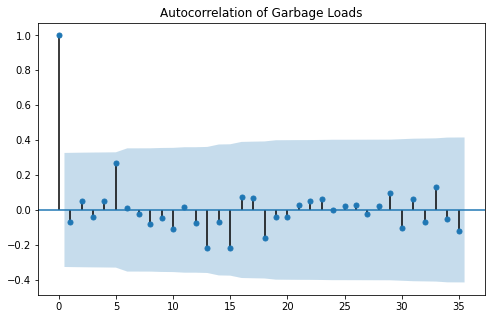

In [41]:
single_tract = tract_loads[tract_loads.fips == sample_tracts[0]].reset_index(drop=True)
single_tract = clean_single_tract_data(single_tract)

G = single_tract.garbage.fillna(0)
R = single_tract.recycling.fillna(0)
single_tract['Fraction'] = (R)/(G+R)

data = single_tract.garbage.to_numpy()[-36:]
ax = plot_acf(data, lags=35,title ='Autocorrelation of Garbage Loads')

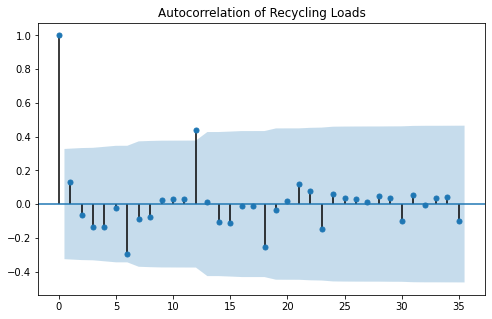

In [42]:
data = single_tract.recycling.to_numpy()[-36:]
ax = plot_acf(data, lags=35,title ='Autocorrelation of Recycling Loads')

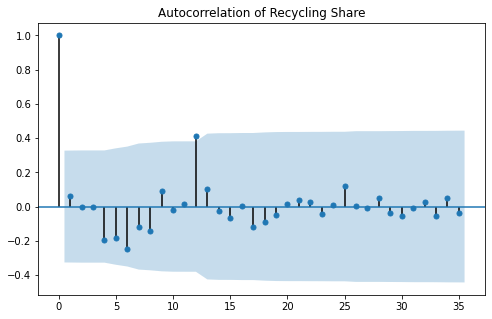

In [43]:
data = single_tract.Fraction.to_numpy()[-36:]
ax = plot_acf(data, lags=35,title ='Autocorrelation of Recycling Share')

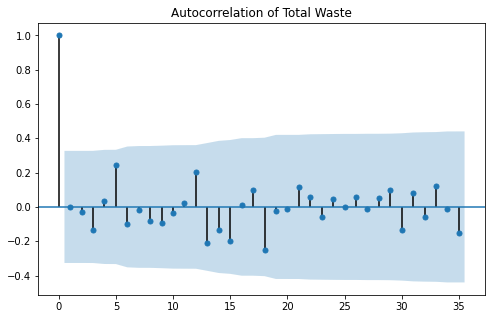

In [44]:
data = single_tract.total_waste.to_numpy()[-36:]
ax = plot_acf(data, lags=35,title ='Autocorrelation of Total Waste')

##### 2.2.2. Study for tract with fips **48453002002**

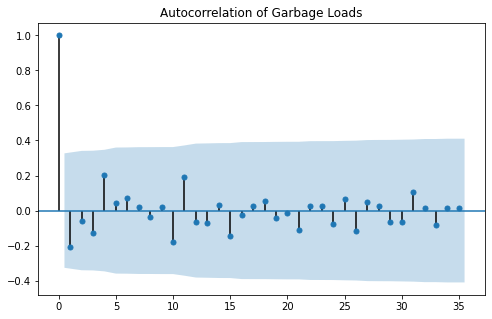

In [45]:
single_tract = tract_loads[tract_loads.fips == sample_tracts[1]].reset_index(drop=True)
single_tract = clean_single_tract_data(single_tract)

G = single_tract.garbage
R = single_tract.recycling
single_tract['Fraction'] = (R)/(G+R)

data = single_tract.garbage.to_numpy()[-36:]
ax = plot_acf(data, lags=35,title ='Autocorrelation of Garbage Loads')

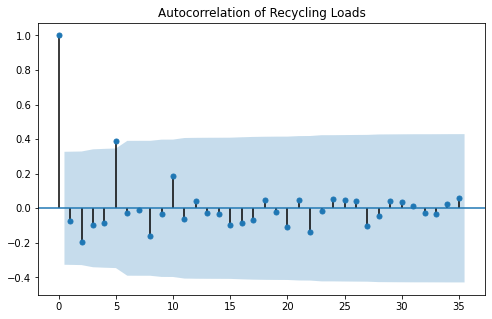

In [46]:
data = single_tract.recycling.to_numpy()[-36:]
ax = plot_acf(data, lags=35,title ='Autocorrelation of Recycling Loads')

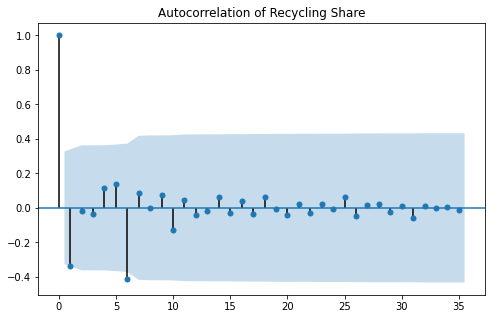

In [47]:
data = single_tract.Fraction.to_numpy()[-36:]
ax = plot_acf(data, lags=35,title ='Autocorrelation of Recycling Share')

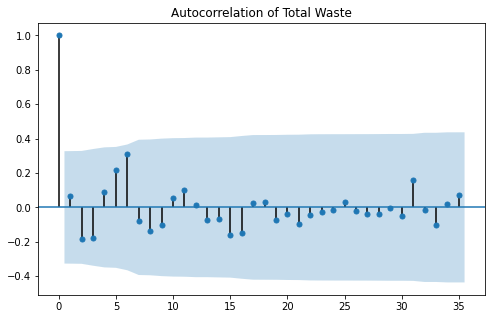

In [48]:
data = single_tract.total_waste.to_numpy()[-36:]
ax = plot_acf(data, lags=35,title ='Autocorrelation of Total Waste')

**Correlation of total waste and recycling share**

We now want to explore if theres correlation between the total waste and recycling share. This could help us think if we could forecast series individually or to forecast both in parallel since they might have important complimentary information.

For the analysis we're going to check the correlation of the key indicators of the sample tracts that we've seen before. We just use a simple correlation.Here of course we're not thinking in causality but in correlation that could help predictions.

In [49]:
alt.Chart(tract_loads.query('fips in @fips_sample')).mark_point().encode(
    x='total_waste:Q',
    y='recycling_share:Q',
    color='fips'
).properties(
    title="Total waste vs recycling share in a sample of fips"
)

alt.Chart(...)

In general the behavior seems to be that the values for a series are more clusterized than correlated. thoush some series exhibit some degree of linear correlation. This however, could help a model that uses information of multiple parallel series, such as Nbeats or the fusion transformer. However the implementation might be too overkill for the few datapoints we handle.

We then can calculate a correlation for each of the series. To eliminate the trend effect we can difference and take the correlation.

In [50]:
tract_loads.query('fips in @fips_sample').groupby('fips').apply(lambda g: g['total_waste'].diff().corr(g['recycling_share'].diff()))

fips
48453000304    0.271949
48453000402   -0.232660
48453000604   -0.413052
48453001716    0.136232
48453001745   -0.170307
48453001755    0.212762
48453001777    0.140144
48453001823   -0.093276
48453001864   -0.071300
48453002113   -0.253701
dtype: float64

We find that after differencing the correlations are low, which means that the random variations we see in the series after detrending seem to be uncorrelated.

##### 2.2.3. Conclusion of series analysis

We've observed that the series at the tract level are quite noisy. However, the noise though grat still seems to be bounded and medium to long term trends can be seen in the waste and recycling patterns.

For autocorrelations, in both cases, a similar behavior is observed. The autocorrelation seen for the four times series of is not significant for 35 lapses. This indicates that there is not a significat periodic/seasonal behavior in the time series over time. This conclusion allows for the additional work to pass over the modelling of seasonal behavior.

The observations shown here are representative of the general behavior. During the development of this work about 50% of all time series present in the data were observed and the behavior shown above persisted. This allows for the conclusion done for this two cases to be extended to all other time series. 

#### 2.3. Forecasting volume and recycling share

We now delve into the prediction of future trends. We remind that we want to predict both the total waste and recycling since its easier to reason in terms of those two variables to compare tracts.

We want to be able to do a monthly forecast. We note, however, that the lack of seasonality makes the series quite noisy. However, there is still a general trend that shows in the data that we belive is important to capture since the overall recycling of the months is around that trend.

In addition, training over the months allows for predicting trend changes for recent timestamps. It could be possible to do a forecast for the quarter instead of for the whole year and figure out recent trend changes. This is also related to the fact that we tried to explore yearly timeseries but there timeseries forecasting did not seem appropate since it tried to predict the mean and the changes are abrupt. There it makes more sense to do something similar to what we did in the initial EDA where we calculated percentage changes year to year


**Model**

For the model, we choose to use the library prophet since its method has some advantages:

1. Prophet is a modular model and we can choose to model trend alone and add seasonal components. For our data we've seen that we want to model trend alone.
2. The model handles missing data. This aids us to reduce the preprocessing load since imputation on this data is not trivial. We also figured this was the best option with the available data given time constrains
3. This model gives probabilistic bound estimates for prediction
4. Prophet has an integrated cross validation scheme that made simpler the evaluation of performance.

**Note:** Given the time constraints we did not delved into other models. Nonetheless, it would have been appropiate to creat a benchmark of different models and cross validate them to find the best alternative, we leave that as a point of future work.

##### 2.3.1. Single tract total waste forecast
Let's do the forecast for the waste of a single tract and qualitatevily analyze how the model behaves

In [51]:
single_tract = tract_loads[tract_loads.fips == '48453001832'].query("load_date>='2012-01-01' and load_date<'2022-01-01'")

m = Prophet(
    weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False, 
    mcmc_samples=500)

m = m.fit(single_tract.rename(columns={'load_date': 'ds', 'total_waste': 'y'}))

**Note:** We also tried to smooth out the series but there we found that the smoothed series seemed to show more abrupt changes and was quite sensible to missing months. This made trend prediction harder. We stayed with the prediction of the trend over the noisy month series.

In [52]:
horizon = m.make_future_dataframe(1, freq='MS')
forecast = m.predict(horizon)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
111,2021-04-01,60301.941755,48602.039406,72017.931506,57347.326150,63324.930211,0.0,0.0,0.0,0.0,0.0,0.0,60301.941755
112,2021-05-01,60174.393133,48315.515641,71017.746432,57143.898297,63306.667197,0.0,0.0,0.0,0.0,0.0,0.0,60174.393133
113,2021-06-01,60042.592889,47886.618157,71616.795207,56911.232367,63258.993660,0.0,0.0,0.0,0.0,0.0,0.0,60042.592889
114,2021-07-01,59915.044266,48076.240158,72712.369432,56676.847655,63253.943838,0.0,0.0,0.0,0.0,0.0,0.0,59915.044266
115,2021-08-01,59783.244022,47644.919440,72418.445417,56440.058455,63242.631323,0.0,0.0,0.0,0.0,0.0,0.0,59783.244022


Of the forecast we can observe both the plot of the reconstructed forecast and the estimation of the model components

Text(0.5, 1.0, 'Real data points agains prophet reconstructed prediction and 80% CI')

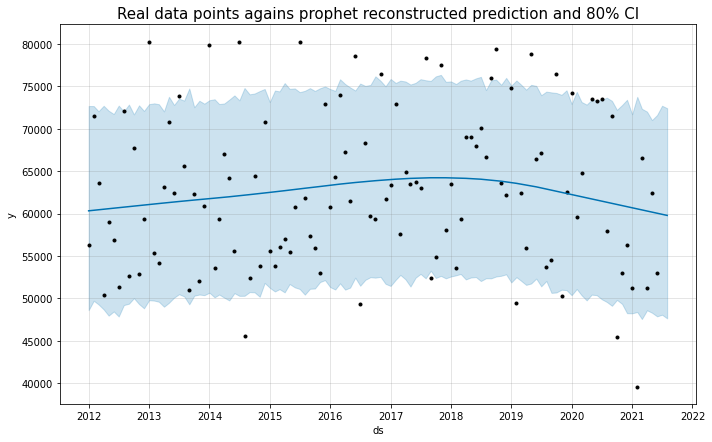

In [53]:
f = m.plot(forecast)
ax = f.gca()
ax.set_title("Real data points agains prophet reconstructed prediction and 80% CI", size=15)

Plot components, in this case we only have the trend

Text(0.5, 1.0, 'Prophet model components and 80% CI')

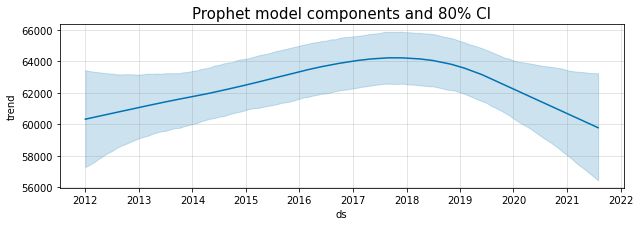

In [54]:
f = m.plot_components(forecast)
ax = f.gca()
ax.set_title("Prophet model components and 80% CI", size=15)

We see that the models captures the trend in the data and that the coverage seems to be good. Note that the prediction interval has to be wide in order to accomodate the high variation across months.

The idea is to replicate this process across all tracts, predicting both total waste and recycling share.

##### 2.3.2. Models performance and parameter optimization
We saw that the monthly data tends to have a considerable amount of variability, it is thus important to be able to generate models that could generalize well and avoid overfitting. One key step towards this is using error validation schemes, since that will give us an idea of how a model with certain parameters will behave in the future.

We took the first steps to avoid overfitting by studyng seasonalities and defining that we were going to train models that do not consider yearly seasonalities.

The prophet model is left with the task of predicting the trend off the data and the associated uncertainty. Though our initial model seems to detect trend variations, we can try to tune models with better parameters.

**Validation scheme**

The validation scheme is the tool that will give us and idea of the error we expect by using the model . In general, we would prefer a model that given a training set of a certain timeframe, is better at predicting the horizon. For the validation scheme we will consider the following

1.  Well try to use the same base parameters to train all single tract models. This can be justified because were looking for models that generalize well and we've seen similar patterns of monthly variance and trend change across different tracts. Also, we've established that total waste and recycling share series share commonalities in their behavior.
3. For a single tract, we calculate performance by using a rolling timeseries cross-validation scheme that uses the previous years to predict the next 12 months. We use as validation the years 2019-2021. 
2. In order to calculate performance metrics for a 'model' (selection of parameters)

Here we define the variables that will rule the cross validation

In [55]:
CV_CUTOFFS = pd.date_range(start='2019-01-01', end='2020-12-01', freq='3MS')
CV_HORIZON = '366 days'

the last cutoff+horizon should not be grater than the last day of data

In [56]:
CV_CUTOFFS

DatetimeIndex(['2019-01-01', '2019-04-01', '2019-07-01', '2019-10-01',
               '2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='3MS')

For each of the cutoffs we try to predict the next 12 months, then we evaluate metrics by taking the mean of the horizons mae as stated in the previous section

**Metrics** 

Given our context, we will focus on the MAE metric because of two reasons.

1. We want a metric that is fairly robust to high residuals influence, since we know there could be high variability across months in a year for both total waste and recycling share.
2. There does not seem to be an initial motivation to handle asymetry (ie. overshooting the forecast is more important than undershooting or viceversa)

the mae is also simple to interpret.

We can find the metric in the `performance_metrics` function of prophet.

In [57]:
def get_tract_mae(df_cv):
  """
  From a prophet cv dataframe of tract forecast with predictions for each cutoff, 
  calculate the overall mae (across cutoffs and horizons)
  """
  df_p = performance_metrics(df_cv, rolling_window=1)

  return df_p.mae.iloc[0]

Though at this time we will only focus on the total average mae across horizons, we note that in the future, studying the behavior of the error as the horizon goes farther into the future is key to understanding degration in performance and perhaps propose better models.

##### 2.3.3. Tunning
We've established both the metrics and the validatoin scheme, now we can setup the tunning process to find the best parameters to train the prophet models.

For simplicity, were going to tune only the parameters for the recycling series. We asume the waste will have a similar changepoint prior (relative to the scale since we've seen it has similar relative variability)

In [58]:
def train_single_model(tract_data, target, prophet_parameters):
  """
  Trains a prophet for a single tract, 
  """
  fitted_model = Prophet(**prophet_parameters).fit(
      tract_data.rename(columns={'load_date': 'ds', target: 'y'}))
  return fitted_model

def score_single_model(m):
  """
  Given a trained model, performs cross validation 
  and then calculate the metric that we defined before
  """
  df_cv = cross_validation(m, cutoffs=CV_CUTOFFS, horizon=CV_HORIZON, parallel='processes')
  tract_mae = get_tract_mae(df_cv)

  return tract_mae

def bulk_train_and_cv(tract_loads, target, model_parameters):
  """
  Takes a df with series for multiple fips
  trains a prophet for each and cross validates the scores

  Args:
    tract_loads: df with series for multiple fips
    target: name of the target column that represents timeseries
    model_parameters: common parameters to train all models
  """
  models = tract_loads.groupby('fips').apply(lambda x: train_single_model(x, target, model_parameters))
  cv_scores = models.apply(score_single_model)

  return models, cv_scores

In [59]:
sample_tracts = tract_loads.fips.sample(n=10, random_state=52)

The only parameter that we might want to vary in the current model is the prior of the changepoint since is the one that defines how sensible is the model to trend changes. Remember that with the tunning we want to find a parameter that gives the best possible performance as assesed by our cross validation scheme.

In [60]:
base_model_params = dict(
    # no seasonalities
    weekly_seasonality=False, 
    daily_seasonality=False, 
    yearly_seasonality=False,
    changepoint_range=0.9  # since we want to be able to detect recent trend changes
    # mcmc_samples=100  # no mcmc in order to reduce training time. Though this leaves out bound estimates
)

changepoint_scales = np.logspace(start=-2, stop=1, num=4, base=10)
changepoint_scales

array([ 0.01,  0.1 ,  1.  , 10.  ])

Here, the search across the prior space is performed.

In [61]:
filtered_tract_loads = tract_loads.query("load_date>='2014-01-01' and load_date<'2021-12-01'")
filtered_tract_loads.load_date.max()

Timestamp('2021-07-01 00:00:00')

In [ ]:
best_params = None
best_score = None
best_models = None

for i, pc in enumerate(tqdm(changepoint_scales)):
  # sets up the variable parameter for this particular trial
  variable_params = dict(
      changepoint_prior_scale=pc
  )
  print(f"Running trial {i} with parameters {variable_params}")
  
  sample_tract_loads = filtered_tract_loads.query('fips in @sample_tracts')

  # train models on recycling share series and calculate cv scores
  model_parameters = {**base_model_params, **variable_params}
  models, cv_scores = bulk_train_and_cv(sample_tract_loads, 'recycling_share', model_parameters)

  mean_cv_score = cv_scores.mean()

  # update best score and params
  if best_score is None or mean_cv_score < best_score:
    best_score = mean_cv_score
    best_params = model_parameters
    best_models = models

  print(f'Score for trial {i}: {mean_cv_score}; current best score: {best_score}')

In [63]:
print(f"best mean mae: {best_score}")
print(f"best params: {best_params}")

best mean mae: 0.038849967634342994
best params: {'weekly_seasonality': False, 'daily_seasonality': False, 'yearly_seasonality': False, 'changepoint_range': 0.9, 'changepoint_prior_scale': 1.0}


We find that the best parameter corresponds to a prior scale of 1, which is a model relatively sensible to trend changes.

Lets plot some of the models that were optimized, remember that each tract series requires a model, its just that all train with the same hyperparameters.

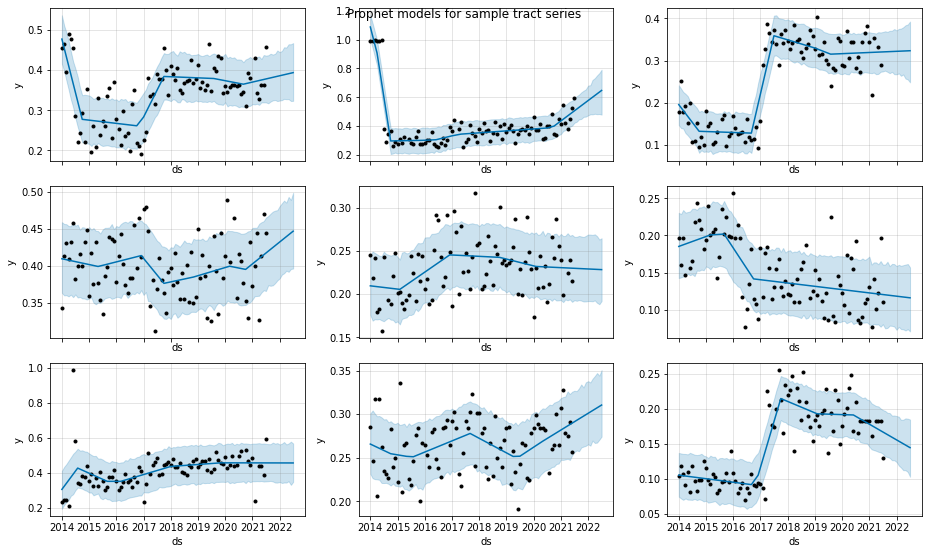

In [64]:
fig, axs = plt.subplots(len(best_models[0:9])//3, 3, figsize=(13, 7.8), sharex=True) 

for model, ax in zip(best_models[0:9], axs.ravel()):
  future = model.make_future_dataframe(periods=12, freq='MS')
  forecast = model.predict(future)

  plot(model, forecast, ax=ax, figsize=(13/3,7.8/3))

plt.suptitle("Prophet models for sample tract series")
plt.tight_layout()
fig.show()

Note that many times changes are abrupt, yet the model tracks these and at the end points towards a linear trend which hopefully encapsulates the trend for next year.

##### 2.3.4. Forecast for all tracts
Now, lets train a model for each tract and generate the forecast for 2022. 

The information is stored at a single data frame.

With the following columns:

* 'yhat': prediction of time series
* 'yhat_lower': lower bound of time series
* 'yhat_upper': upper bound of time series
* 'trend': prediction of trend
* 'trend_lower': lower bound of trend
* 'trend_upper': upper bound of trend
* 'tract': tract's id
* 'load_date': prediction date.
* 'target': whether the prediction corresponds to the total waste or the recycling share

Lets use the following parameters to build the models.

In [65]:
model_parameters = dict(
    changepoint_prior_scale=1,
    # no seasonalities
    weekly_seasonality=False, 
    daily_seasonality=False, 
    yearly_seasonality=False,
    changepoint_range=0.9,  # since we want to be able to detect recent trend changes
    # mcmc_samples=100  # no mcmc in order to reduce training time. Though this leaves out bound estimates
)

We'll make all models predict over the same horizon, the year 2022. This means taht for training we will take all series until the end of 2021.

In [66]:
future = pd.DataFrame({'ds': pd.date_range(start='2022-01-01', end='2022-12-01', freq='MS')})
future

,ds
0,2022-01-01
1,2022-02-01
2,2022-03-01
3,2022-04-01
4,2022-05-01
5,2022-06-01
6,2022-07-01
7,2022-08-01
8,2022-09-01
9,2022-10-01


Here we define functions to generate the forecasts and process the series in bulk.

In [67]:
def generate_forecast(model, future):
  """
  Model predictions for the given future df
  """
  return model.predict(future)

def bulk_train_and_forecast(tract_loads, target, model_parameters, future):
  """
  Takes a df with series for multiple fips and calculates the forecast for each

  Args:
    tract_loads: df with series for multiple fips
    target: name of the target column that represents timeseries
    model_parameters: parameters to train all models
    future: common horizon to generate predictions for all tracts
  """
  forecasts_list = []

  for fips, tract_data in tqdm(tract_loads.groupby('fips')):
    # iterate over the single fips series
    try:
      # train model
      model  = train_single_model(tract_data, target, model_parameters)
      # generate forecast
      forecast = generate_forecast(model, future)
      forecast = forecast[['ds', 'yhat','yhat_lower','yhat_upper','trend','trend_lower','trend_upper']]
      # this adds the fips (series index) as  column to each forecast
      forecast = forecast.assign(fips=fips, target=target)

      forecasts_list.append(forecast)
    except ValueError as e:
      # some series fail since all the observations are na (eg a tract wih no recycling records)
      print(e)

  return pd.concat(forecasts_list)

We just generate forecast for both total waste and recycling share for all fips.

##### 2.3.5. Total waster forecasts

In [68]:
filtered_tract_loads = tract_loads.query("load_date>='2010-01-01' and load_date<'2021-12-01'")

In [69]:
total_waste_forecasts = bulk_train_and_forecast(
    filtered_tract_loads, 'total_waste', model_parameters, future)

  0%|          | 0/215 [00:00<?, ?it/s]

Dataframe has less than 2 non-NaN rows.


 93%|█████████▎| 200/215 [05:54<00:26,  1.75s/it]

Dataframe has less than 2 non-NaN rows.


 94%|█████████▍| 202/215 [05:56<00:17,  1.34s/it]

Dataframe has less than 2 non-NaN rows.


 95%|█████████▍| 204/215 [05:57<00:12,  1.15s/it]

Dataframe has less than 2 non-NaN rows.


 98%|█████████▊| 211/215 [06:08<00:06,  1.59s/it]

Dataframe has less than 2 non-NaN rows.


100%|██████████| 215/215 [06:13<00:00,  1.74s/it]


##### 2.3.6. Recycling share forecasts





In [70]:
recycling_share_forecasts = bulk_train_and_forecast(
    filtered_tract_loads, 'recycling_share', model_parameters, future)

  0%|          | 0/215 [00:00<?, ?it/s]

Dataframe has less than 2 non-NaN rows.


 93%|█████████▎| 200/215 [05:56<00:27,  1.82s/it]

Dataframe has less than 2 non-NaN rows.


 94%|█████████▍| 202/215 [05:58<00:17,  1.38s/it]

Dataframe has less than 2 non-NaN rows.


 95%|█████████▍| 204/215 [06:00<00:13,  1.18s/it]

Dataframe has less than 2 non-NaN rows.


 98%|█████████▊| 211/215 [06:11<00:06,  1.64s/it]

Dataframe has less than 2 non-NaN rows.


100%|██████████| 215/215 [06:16<00:00,  1.75s/it]


In [71]:
recycling_share_forecasts.head()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper,fips,target
0,2022-01-01,0.211621,0.159003,0.271265,0.211621,0.209752,0.213616,48209010908,recycling_share
1,2022-02-01,0.207243,0.151573,0.267716,0.207243,0.204850,0.209612,48209010908,recycling_share
2,2022-03-01,0.203289,0.143930,0.261943,0.203289,0.200480,0.206052,48209010908,recycling_share
3,2022-04-01,0.198911,0.137372,0.258427,0.198911,0.195605,0.202174,48209010908,recycling_share
4,2022-05-01,0.194674,0.133707,0.249529,0.194674,0.190943,0.198321,48209010908,recycling_share


In [72]:
tract_forecasts = pd.concat([total_waste_forecasts, recycling_share_forecasts])
tract_forecasts.rename(columns={'ds': 'load_date'})
tract_forecasts.sample(5)

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper,fips,target
10,2022-11-01,415727.571376,360598.976500,477403.468443,415727.571376,410648.447768,421482.016587,48453001714,total_waste
8,2022-09-01,0.360743,0.308563,0.411862,0.360743,0.352593,0.368849,48453001000,recycling_share
11,2022-12-01,0.164452,0.104261,0.219701,0.164452,0.156496,0.172496,48209010908,recycling_share
0,2022-01-01,0.363508,0.327354,0.398237,0.363508,0.360598,0.367111,48453001747,recycling_share
5,2022-06-01,82390.244792,70511.687190,94419.841786,82390.244792,81507.779864,83263.756495,48453000801,total_waste


In [73]:
# tract_forecasts.to_parquet('/content/drive/MyDrive/GeoNEAS/data/tract_forecasts.parquet')

#### 2.4. Summary of forecast work

In this stage of the work the following tasks were performed. First, time series for the total load of waste, load of garbage and load recyling for each tract were generated from the data provided by the *data acquisition* notebook. Second, these time series were processed through clipping. The resulting series were used to create a fourth time series, the share of recyling over total waste in time. 

The series were then studied with the autocorrelation function to see whether they presented any seasonal behavior. The results clearly showed the lack of any annual seasonal behavior. 

The model of prophet is selected as the one to use for the modelling, with no consideration for any seasonal behavior. This model is train on the series of share of recycling and the total waste.
 
The total waste series and recycling share were cross validated for the selection of parameter. The only parameter to change was the prior. The results of cross validation given was an optimal value of 1. The seletion of parameter was followed by the training of prophet models on the time series of share of recycling and total waste for all tracts.

#### 2.5. Conclusion

The objectives of this stage were achieved as the forecast of the relevant series were created with a model was cross validated for optimal parameters, but some important point of improvement need to be address in further work. First, it will be good to consider other features during the training. One relevant feature that could be included is the cities population. Second, it would be necessary to consider additional models and compare their performance to the one achieved by the prophet model. By trying differemt models, a better model can be selected. Possible candidates include a Holt-Winter Exponential Smoothign and an ARIMA.

Another point to observe is the time series at a higher level of granularity (at the level of weeks) or also study the forecast of trend at a quaterly basis.

### 3. Clusters construction

Coming back to our global picture, on one hand we want to see how the tracts will behave in waste, and thus we built the forecasts. the other part of our idea of product is to add context information (not waste) to each tract and then use that information to group tracts of similar context but perhaps disparate waste trends.


**Objective**

This section aggregates waste, socioeconomic and vulnerability datasets to calculate clusters of similar socioeconomic contexts.

#### 3.1. Data
The data for socioeconomic variables was cross referenced and aggregated in the notebook of data preparation for clustering.

//TODO reference this better

In [74]:
# Pandas config
pd.set_option('display.max_columns', 500)
# Aggregated data path database
data = pd.read_csv(path + 'agg_vars_tract.csv')
data.head(2)

,Unnamed: 0,epl_unemp,data_year,theme_1,st,flag_per_capita_income_is,st_abbr,epl_pov,location,estimated_unemployed,state,unique_id,mp_pci,flag_percentage_of_persons_1,m_pci,area_sqmi,flag_percentage_of_civilian,year,fips,estimated_persons_below,unemployment_rate_estimate,county,sum_of_flags_for_socioeconomic,e_nohsdp,percentage_of_persons_with,m_nohsdp,mp_pov,percent_per_capita_income,e_daypop,mp_nohsdp,mp_unemp,m_pov,m_totpop,percentile_ranking_for,epl_nohsdp,estimated_percent_persons,sum_four_themes,stcnty,flag_percentage_of_persons,m_unemp,epl_pci,estimated_total_population,sum_of_series_for,per_capita_income_estimate,e_uninsur,ep_uninsur,epl_limeng,epl_minrty,f_theme3,f_total,flag_minority_all_persons,flag_persons_age_5_who_speak,m_minrty,m_uninsur,minority_all_persons_except,mp_limeng,mp_minrty,mp_uninsur,percentage_of_persons_age,percetage_of_minority_all,persons_age_5_who_speak,persons_age_5_who_speak_1,persons_with_no_high_school,rpl_theme3,spl_theme3,total_population_estimate,GARBAGE COLLECTIONS,RECYCLING - SINGLE STREAM,total_waste,pct_garbage
0,0,0.3658,2018-01-01T00:00:00,Socioeconomic Status,48,0,TX,0.7033,"Census Tract 18.06, Travis County, Texas",189,TEXAS,1075,2805,0,2805,0.75,0,2018,48453001806,1626,4.9,Travis,0,1122,26.6,275,0.085,16477.0,3782,0.070,3.0,565,732,0.6779,0.7250,0.227,3,48453,0,118,0.7742,7191,2.5682,16477,2729,0.380,0.9277,0.7687,1,3,0,1,854.6,631,6008,6.0,0.083,7.2,0.243,0.835,1581,426.1,51,0.8680,1.6963,7191,1.281477e+06,565324.533623,1.846801e+06,0.69389
1,1,0.5004,2018-01-01T00:00:00,Socioeconomic Status,48,0,TX,0.5217,"Census Tract 20.04, Travis County, Texas",115,TEXAS,1130,10248,0,10248,0.33,0,2018,48453002004,384,6.0,Travis,0,90,4.6,62,0.057,39587.0,4346,0.032,3.9,147,174,0.2983,0.1522,0.157,2,48453,0,76,0.1544,2442,1.3287,39587,480,0.197,0.0842,0.3435,0,2,0,0,269.7,159,956,2.2,0.107,6.0,0.004,0.391,10,52.3,159,0.1896,0.4277,2442,6.868628e+05,283406.347230,9.702691e+05,0.70791


#### 3.2. Feature selection

One key aspect of analyzing this data was to correctly establish the meanings of the different columns. Here we show the result of that manual labor.

Transforming to numerical features only. Key: FIPS
**County descriptive**

- fips: ID

- area_sqmi: Area in Square miles

- county: County (3 counties in dataset)

  

**Unemployed**

- epl_unemp: Percentile Percentage of civilian (age 16+) unemployed estimate
- estimated_unemployed: Civilian (age 16+) unemployed estimate, 2014- 2018 ACS
- unemployment_rate_estimate: Unemployment rate estimate
- mp_unemp: Unemployment Rate estimate MOE

- (DISCARD) flag_percentage_of_civilian: Flag - percentage of civilian unemployed is in the 90th percentile
-  (DISCARD - DUPLICATE) m_unemp: Civilian (age 16+) unemployed estimate MOE, 2014-2018 ACS

  

**Per capita income**

- mp_pci: Per capita income estimate MOE, 2014-2018 ACS

- per_capita_income_estimate: Per capita income estimate, 2014- 2018 ACS

- mp_pci: Per capita income estimate MOE, 2014-2018 ACS

- epl_pci: Percentile per capita income estimate

- (DISCARD) flag_per_capita_income_is: Flag - per capita income is in the 90th percentile (1 = yes, 0 = no)  
- (DISCARD- DUPLICATE) percent_per_capita_income: Per capita income estimate, 2014- 2018 ACS
- (DISCARD- DUPLICATE) m_pci: Per capita income estimate MOE, 2014-2018 ACS 

**Poverty**

- estimated_persons_below: Estimated persons below poverty
- m_pov: Persons below poverty estimate MOE, 2014-2018 ACS
- epl_pov: Percentile Percentage of persons below poverty estimate
- mp_pov: Percentage of persons below poverty estimate MOE
- estimated_percent_persons: Percentage of persons below poverty estimate


- (DISCARD) flag_percentage_of_persons: Flag - the percentage of persons in poverty is in the 90th percentile (1 = yes, 0 = no)
- (DISCARD) flag_percentage_of_persons_1: Flag-Percentage of persons in poverty is in the 90th percentile

**High School Diploma**

- e_nohsdp: Persons (age 25+) with no high school diploma estimate, 2014- 2018 ACS
- m_nohsdp: Persons (age 25+) with no high school diploma estimate MOE, 2014-2018 ACS

- percentage_of_persons_with: Percentage of persons with no high school diploma (age 25+) estimate
- mp_nohsdp: Percentage of persons with no high school diploma (25+) estimate MOE
- epl_nohsdp: Percentile Percentage of persons with no high school diploma (age 25+) estimate
- persons_with_no_high_school:Percentage of persons with no high school diploma
  

**Speak English**

- epl_limeng: Percentile percentage of Persons (age 5+) who speak English "less than well" estimate, MOE 2014- 2018 ACS

- percentage_of_persons_age: Percentage of Persons (age 5+) who speak English "less than well" estimate, 2014- 2018 ACS

- persons_age_5_who_speak: Percentage of Persons (age 5+) who speak English "less than well" estimate, 2014- 2018 ACS

- persons_age_5_who_speak_1:

- flag_persons_age_5_who_speak: Flag - Persons (age 5+) who speak English "less than well" estimate, MOE 2014- 2018 ACS
  

**Adjunct Variables**

- e_daypop: Adjunct variable - Estimated daytime population, LandScan 20

- e_uninsur: Adjunct variable - Uninsured in the total civilian noninstitutionalized population estimate MOE, 2014-2018 ACS

- ep_uninsur: Adjunct variable - Uninsured in the total civilian noninstitutionalized population estimate MOE, 2014-2018 ACS

- m_uninsur: Adjunct variable - Uninsured in the total civilian noninstitutionalized population estimate MOE, 2014-2018 ACS

- mp_uninsur: Adjunct variable - Percentage uninsured in the total civilian noninstitutionalized population estimate MOE, 2014-2018 ACS

  
  

**Total Population**

- m_totpop: Population estimate MOE, 2014-2018 ACS

- estimated_total_population: Population estimate, 2014- 2018 ACS

- (DISCARD - DUPLICATED) total_population_estimate

  
  

**Minority**

- flag_minority_all_persons: Flag- Minority (all persons except white, nonHispanic) estimate, 2014-2018 ACS

- epl_minrty: Percentile percentage minority (all persons except white, non - Hispanic) estimate

- f_theme3: Sum of flags for Minority Status/Language theme

- m_minrty: Minority (all persons except white, nonHispanic) estimate, MOE 2014-2018 ACS

- minority_all_persons_except: Number of people who identify as Minority Estimate

- percetage_of_minority_all: Percentage of Minority (all persons except white, nonHispanic) estimate, 2014-2018 ACS

- rpl_theme3: Percentile ranking for Minority Status/Language theme

- spl_theme3: Sum of series for Minority Status/Language theme

**Flags**

- sum_of_flags_for_socioeconomic: Sum of series for Socioeconomic theme

- f_total: Sum of flags for the four themes

- sum_four_themes: Sum of flags for the four themes

- percentile_ranking_for: Percentile ranking for Socioeconomic theme summary

- sum_of_series_for: Sum of series for Socioeconomic theme

  

**Others**

- mp_limeng: MP_LIMENG ?

- mp_minrty: mp_minrty ?

**Waste**

- GARBAGE COLLECTIONS: Quantity of garbage collections

- RECYCLING - SINGLE STREAM: Quantity of recycling

- total_waste: Garbage + Recycling

- pct_garbage: Pct of Garbage / Total waste

Note that there are many features with similar definitions and that we've observed with different values. In order to make the clusters more meaningful, we are going to select a subset of these features to generate the clusters.

In [75]:
def subset_dataset(
    df: pd.core.frame.DataFrame,
    keep_cols: List):
  # Delete unnecesary columns columns
  final = df[keep_cols]
  return final

def feature_engineering(
    df: pd.core.frame.DataFrame,
    cluster_cols: List):
  # Delete unnecesary columns 
  final = df[cluster_cols]
  # Categorical variables
  final = pd.get_dummies(final)
  # Standardize total population
  final['estimated_total_population'] = final['estimated_total_population']/sum(final['estimated_total_population'])
  # Normalize variables
  max_area = np.max(final['area_sqmi'])
  min_area = np.min(final['area_sqmi'])
  final['area_sqmi'] = (final['area_sqmi'] - min_area) / (max_area - min_area)
  
  return final

As we mentioned before, we want a subset of features. The selection we decided based on our criteria of what features might a policy maker look at when quickly comparing different regions in their likelihood to have receive similar programs or campaings toward waste and recycling. For example we selected income level, unemployment, poverty and education.

However, we note that there's a huge point of improvement in allowing the users of our product, policy makers, parametrize the features that they deem important for clustering. Thus leaving them the option to parametrize and discover clusters useful to generate targets and strategies. For example including age and education level to generate a clusters that will allow for age-targeted and education campaigns.

In [76]:
KEEP_COLS = ['fips', 'area_sqmi', 'epl_unemp', 'epl_pci', 
             'epl_pov', 'epl_nohsdp', 'epl_limeng', 'ep_uninsur',
             'estimated_total_population', 'epl_minrty',
             'GARBAGE COLLECTIONS', 'RECYCLING - SINGLE STREAM',
             'total_waste', 'pct_garbage']
CLUSTER_COLS = ['fips', 'area_sqmi', 'epl_unemp', 'epl_pci', 
             'epl_pov', 'epl_nohsdp', 'epl_limeng', 'ep_uninsur',
             'estimated_total_population', 'epl_minrty']

final_df = subset_dataset(data, KEEP_COLS)
final_df = feature_engineering(final_df, CLUSTER_COLS)
final_df.head()

,fips,area_sqmi,epl_unemp,epl_pci,epl_pov,epl_nohsdp,epl_limeng,ep_uninsur,estimated_total_population,epl_minrty
0,48453001806,0.006898,0.3658,0.7742,0.7033,0.7250,0.9277,0.380,0.007079,0.7687
1,48453002004,0.001815,0.5004,0.1544,0.5217,0.1522,0.0842,0.197,0.002404,0.3435
2,48453000203,0.003510,0.7382,0.1146,0.8736,0.1623,0.0000,0.074,0.001447,0.2562
3,48453001747,0.008956,0.4041,0.3803,0.6853,0.2471,0.3691,0.225,0.005610,0.4219
4,48453001753,0.008835,0.3376,0.0836,0.2066,0.0299,0.1709,0.056,0.001080,0.3816


With the variables chosen, we now move to fitting a clustering model on top of this data. Given the low dimensionality we've decided to move with kmeans since we also wanted to perform some interpretation of the results, which we will do in the form of centroids. 

In [77]:
def fit_kmeans(
    X,
    n_clusters: int):

  kmeans = KMeans(n_clusters=n_clusters, random_state=0)
  preds = kmeans.fit_predict(X)
  #cluster_df = df.copy()
  #cluster_df['cluster_id'] = preds

  score = silhouette_score(X, preds)

  return preds, score

In [78]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_df.drop(columns='fips'))

#### 3.3. Optimal k

Using the silhouette method, we find a suggested number of clusters

In [79]:
results = []

for k in tqdm(range(2, 15)):
  _, score = fit_kmeans(scaled_data, n_clusters = k)
  results.append({'k': k, 'score': score})

scores = pd.DataFrame(results)

scores.sort_values('score',ascending=False)

100%|██████████| 13/13 [00:01<00:00,  9.92it/s]


,k,score
0,2,0.414263
1,3,0.372788
2,4,0.285185
3,5,0.251277
4,6,0.236350
10,12,0.220617
8,10,0.212179
11,13,0.208815
12,14,0.207908
6,8,0.207019


We find that the best quantitative k correspond to two clusters. For our context however, we prefer a more heterogenuous splitting since the idea is to help policy makers look at smaller and more homogenous groups of populations.

In the future adding more features to the context data might help the algorithm generate more tight clusters instead of big ones. In conjunction, there's also the chance to use algorithms that focus more on density, such as dbscan. In preliminary tests we found that tuning the eps to get clusters was proving quite difficult, and it could be better to have more discriminative features.

#### 3.4. Cluster descriptives

As stated before, we define 4 cluster for the challenge. Lets train the model again and see what comes out of the clusters

In [80]:
preds, score = fit_kmeans(scaled_data, n_clusters = 4)
final_df['cluster'] = preds

We tried several number of cluster choosing the lowest number that groups best the census tracts.

In [81]:
final_df.cluster.value_counts(())

2    92
1    50
0    39
3    16
Name: cluster, dtype: int64

Putting the clusters back into the original data, we can see how do the centroids look like in order to have an idea of the cluster.

In [82]:
final_df.groupby('cluster').agg(['mean', 'std'])

fips                area_sqmi           epl_unemp            \
                 mean            std      mean       std      mean       std   
cluster                                                                        
0        4.845300e+10     634.673842  0.009700  0.018151  0.539554  0.244251   
1        4.845300e+10     295.811590  0.057156  0.100335  0.496446  0.258443   
2        4.845301e+10  102013.940515  0.019745  0.023727  0.261220  0.184241   
3        4.845300e+10     256.478852  0.155414  0.242484  0.315669  0.181734   

          epl_pci             epl_pov           epl_nohsdp            \
             mean       std      mean       std       mean       std   
cluster                                                                
0        0.447403  0.222342  0.673767  0.194743   0.452141  0.187864   
1        0.710854  0.130389  0.769448  0.141224   0.754476  0.129707   
2        0.113038  0.078912  0.257858  0.196566   0.110210  0.092266   
3        0.194713  0.144356  0.174231  0.124262   0.205838  0.159868   

        epl_limeng           ep_uninsur           estimated_total_population  \
              mean       std       mean       std                       mean   
cluster                                                                        
0         0.536800  0.229856   0.193282  0.050421                   0.003924   
1         0.833260  0.132510   0.303740  0.066290                   0.005924   
2         0.233474  0.173820   0.091609  0.053081                   0.004125   
3         0.424206  0.231114   0.096000  0.056541                   0.010700   

                  epl_minrty            
              std       mean       std  
cluster                                 
0        0.001956   0.498572  0.112169  
1        0.002319   0.728254  0.083173  
2        0.001526   0.247546  0.142827  
3        0.003272   0.414350  0.206021

We observe that the clusters tend to have disparate behavior in the features. For example they significantly differ in area, unemployment and poverty levels. One can even see correlations of poverty, uninsured and high number of minorities. Here we leave the interpretation of the clusters to the poilicy makers that could have a better sense of austins emergent organization.

What matters to us now is that the clusters seem to group homogeneous groups of tracts, and this could make easier for a policy maker to reason about what could be different with respect to waste for tracts of a single cluster. Perhaps also to generate targeted campaigns per cluster.

### 4. Cluster and forecast analysis

Agin, lets see the big picture, we have now the two main components of our product: a estimaton of the waste trends per tract and and a contextual socioeconomic grouping of the same tracts. Now we can join this data and analyze the trends in light of the tracts context. Here well find our main insights and a framework to aid policy makers further analyze trend behaviors of similar tracts.



#### 4.1. Data loading


We must to obtain cluster, forecast, socioeconomic databases and tract geometries

In [83]:
tract_clusters = pd.read_parquet(path + "tract_clusters.parquet")
tract_forecast = pd.read_parquet(path + "tract_forecasts.parquet")
socioeconomic = pd.read_csv(path +'agg_vars_tract.csv')
tract_basemap = gpd.read_file(path + 'tracts_basemap.geojson')
tract_forecast.fips = tract_forecast.fips.astype("int64")

#### 4.2. Measuring the relative difference in the trends

We are going to compute the difference in the trend considering January and Decenmber as reference. For total waste we calculate the difference showing a decrease trend if the relative number is possitive. On the other hand, for recycling share trend the difference give the relative trend showing a possitive trend if the number is possitive

In [84]:
# datetime configurations
tract_forecast["Month"] = [x.month for x in tract_forecast["ds"]]
tract_diff = tract_forecast[tract_forecast["Month"].isin([1, 12])]
tract_diff["Month"][tract_diff["Month"] == 1] = "Jan"
tract_diff["Month"][tract_diff["Month"] == 12] = "Dec"

# Creating df for recycling and total waste
tract_diff_recycling = tract_diff[tract_diff.target == "recycling_share"].pivot_table(index = "fips",
                                                                            columns = ["Month"],
                                                                            values = "yhat").reset_index()
tract_diff_waste = tract_diff[tract_diff.target == "total_waste"].pivot_table(index = "fips",
                                                                            columns = ["Month"],
                                                                            values = "yhat").reset_index()
# Masuring the differences
tract_diff_waste["total_waste_trend_diff"] = (tract_diff_waste.Jan - tract_diff_waste.Dec)/tract_diff_waste.Jan
tract_diff_recycling["total_recycling_trend_diff"] = (tract_diff_recycling.Jan - tract_diff_recycling.Dec)

tract_diff_waste = tract_diff_waste[["fips", "total_waste_trend_diff"]]
tract_diff_recycling = tract_diff_recycling[["fips", "total_recycling_trend_diff"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


We are going to merge tract forecast with tract cluster. We need to group the forecast per tract obtaining the total waste and recycling share. Besides, we are going to consider the total population and recyling and total waste trends per tract to observ if trend changed

Text(0.5, 1.0, 'Considered tracts in our study')

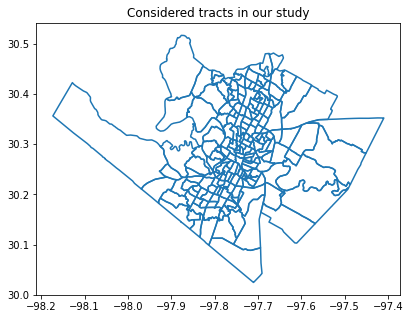

In [85]:
tract_total = tract_forecast.groupby(["fips", "target"])["yhat"].mean().reset_index().pivot_table(index = "fips",
                                                                                    columns = "target",
                                                                                    values = "yhat").reset_index()
tract_total.fips = tract_total.fips.astype("int64")
population = socioeconomic[["fips", "estimated_total_population"]].rename(columns = {"estimated_total_population" : "population"})
#Merge with clusters
tract_total = pd.merge(tract_clusters, tract_total, on = "fips", how = "left")
#Merge with population
tract_total = pd.merge(tract_total, population, on = "fips", how = "left")
# Calculating indicator of waste per person
tract_total["total_waste_per_pop"] = tract_total["total_waste"]/tract_total["population"]
#Merge with recycling and waste trend
tract_total = pd.merge(tract_total, tract_diff_waste, on = "fips", how = "left")
tract_total = pd.merge(tract_total, tract_diff_recycling, on = "fips", how = "left")

#Merge with basemap
tract_basemap.fips = tract_basemap.fips.astype("int64")
tract_total = pd.merge(tract_basemap, tract_total, on = "fips")
tract_total.boundary.plot()
plt.title("Considered tracts in our study")

#### 4.3. Forecast analysis

We are going to analysis the recycling and waste forecast per fips using the average in the year. On the other hand, we conduct an scatterplot analysis of recycling share per total waste and per capita total waste

Text(0.5, 1.0, 'Forecasted mean recycling share distribution per tract')

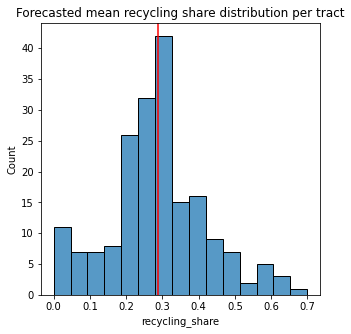

In [86]:
fig = plt.figure(figsize = (5, 5))
sns.histplot(data = tract_total[tract_total.recycling_share >= 0],
             x = "recycling_share")
plt.axvline(tract_total["recycling_share"][tract_total.recycling_share >= 0].mean(),
            ymin = 0, ymax = 50, color = "r")

plt.title("Forecasted mean recycling share distribution per tract")

In the recycling share forecast we obtain 191 census tracts were waste could be forecast. Recycling share has an average of 28.7% and 97 census tracts has a recycling share higher than the average.


Text(0.5, 1.0, 'Forecasted mean total waste distribution per tract')

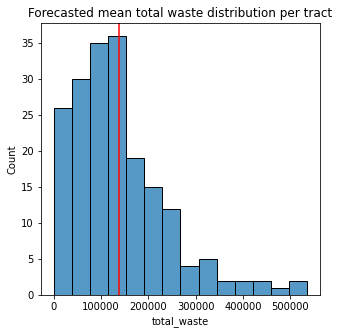

In [87]:
fig = plt.figure(figsize = (5, 5))
sns.histplot(data = tract_total[tract_total.recycling_share >= 0],
             x = "total_waste")
plt.axvline(tract_total["total_waste"][tract_total.recycling_share >= 0].mean(),
            ymin = 0, ymax = 50, color = "r")

plt.title("Forecasted mean total waste distribution per tract")

In the total waste analysis we obtain an average of 138513 pounds and 83 census tracts has a total waste higher than the average.

Text(0.5, 1.0, 'Quadrant analysis of forecasted total volume vs. recycling share')

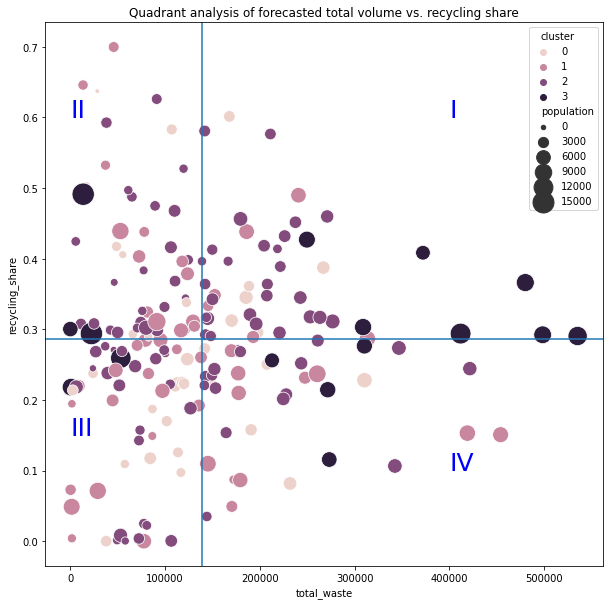

In [88]:
fig = plt.figure(figsize = (10, 10))
sns.scatterplot(data = tract_total[tract_total.recycling_share >= 0],
                x = "total_waste", y = "recycling_share",
                hue = "cluster", size = "population", sizes = (20, 500))
plt.axhline(tract_total["recycling_share"][tract_total.recycling_share >= 0].mean())
plt.axvline(tract_total["total_waste"][tract_total.recycling_share >= 0].mean())

# Add text labels for each quadrant
plt.text(400000, 0.6, "I", fontsize=25, c='b')
plt.text(0, 0.6, "II", fontsize=25, c='b')
plt.text(0, 0.15, "III", fontsize=25, c='b')
plt.text(400000, 0.10, "IV", fontsize=25, c='b')

plt.title("Quadrant analysis of forecasted total volume vs. recycling share")

This graph shows us four different behaviours when total waste and recycling share is analyzed. Considering the average of total waste and recycling share we build four quadrants:

- I. Upper-right quadrant is where census tracts with high recycling share and total waste are located. This is a desirable behaviour where higher rates of waste production generates high rates of recycling.
- II. Upper-left quadrant is where census tracts with high recycling share and low waste production are located. This is the most desirable behaviour.
- III. Lower - left quadrant is where census tracts with low recycling share and waste production are located.
- IV. Lower-right quadrant is where census tracts with low recycling and high waste production are located. This the least desirable behaviour.

In [89]:
# Calculation for mapping
tract_total["Quadrant_analysis_1"] = "I"
first_quadrant = len(tract_total[(tract_total.recycling_share >= 0) &
                                (tract_total.total_waste >= 138512) &
                                (tract_total.recycling_share >= 0.286)])
second_quadrant = len(tract_total[(tract_total.recycling_share >= 0) &
                                (tract_total.total_waste < 138512) &
                                (tract_total.recycling_share >= 0.286)])
tract_total["Quadrant_analysis_1"][(tract_total.recycling_share >= 0) &
                                (tract_total.total_waste < 138512) &
                                (tract_total.recycling_share >= 0.286)] = "II"
third_quadrant = len(tract_total[(tract_total.recycling_share >= 0) &
                                (tract_total.total_waste < 138512) &
                                (tract_total.recycling_share < 0.286)])
tract_total["Quadrant_analysis_1"][(tract_total.recycling_share >= 0) &
                                (tract_total.total_waste < 138512) &
                                (tract_total.recycling_share < 0.286)] = "III"
fourth_quadrant = len(tract_total[(tract_total.recycling_share >= 0) &
                                (tract_total.total_waste >= 138512) &
                                (tract_total.recycling_share < 0.286)])
tract_total["Quadrant_analysis_1"][(tract_total.recycling_share >= 0) &
                                (tract_total.total_waste >= 138512) &
                                (tract_total.recycling_share < 0.286)] = "IV"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In the map we observ the census tracts for the quadrant analysis. In the first view we could see some agrupations of the census tracts per quadrants, however this could be complemented with a geographic analysis

Now, we are going to analyze recycling share and the total waste per capita per census tract. We are going to concetrate in census tracts with population different than zero

Text(0.5, 1.0, 'Initial plot of distribution of forecasted waste per capita for all tracts')

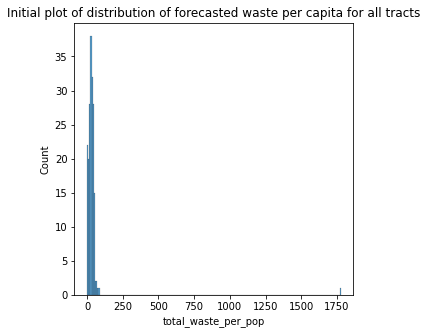

In [90]:
fig = plt.figure(figsize = (5, 5))
sns.histplot(data = tract_total[(tract_total.recycling_share >= 0)],
             x = "total_waste_per_pop")
plt.axvline(tract_total["total_waste_per_pop"][(tract_total.recycling_share >= 0)].mean(),
            ymin = 0, ymax = 50, color = "r")

plt.title("Initial plot of distribution of forecasted waste per capita for all tracts")

We found outlier were the total waste per person is reougly higher than other tracts in Austin. For example, census tracts with low or whitout population consequently the indicator is overrepresented. We decide to drop those values in this analysis

Text(0.5, 1.0, 'Distribution of forecasted waste per capita for all tracts')

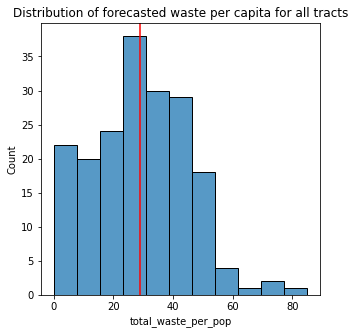

In [91]:
fig = plt.figure(figsize = (5, 5))
sns.histplot(data = tract_total[(tract_total.recycling_share >= 0) &
                                (tract_total.population > 16)],
             x = "total_waste_per_pop")
plt.axvline(tract_total["total_waste_per_pop"][(tract_total.recycling_share >= 0) &
                                (tract_total.population > 16)].mean(),
            ymin = 0, ymax = 50, color = "r")

plt.title("Distribution of forecasted waste per capita for all tracts")

Now we obtain a better representation with indicators from 0.00018 pound per person up to 85 pounds per person. The average od waste production per person is near to 30 punds per person

Text(0.5, 1.0, 'Quadrant analysis of forecasted total volume (per capita) vs. recycling share')

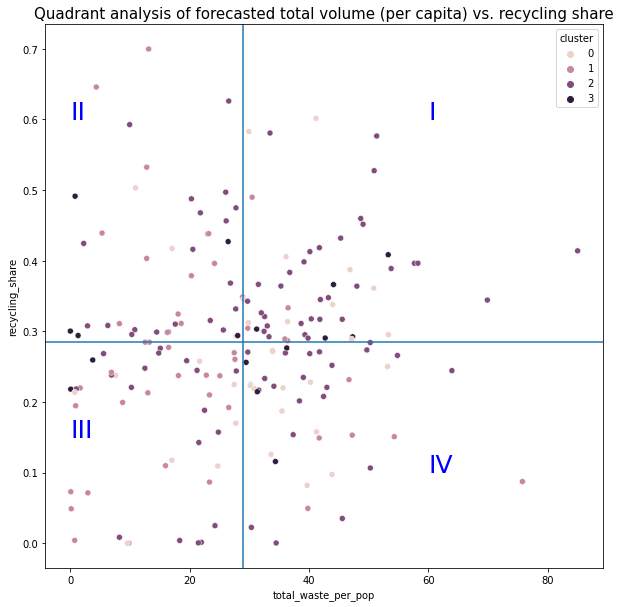

In [92]:
fig = plt.figure(figsize = (10, 10))
sns.scatterplot(data = tract_total[(tract_total.recycling_share >= 0) &
                                (tract_total.population > 16)],
                x = "total_waste_per_pop", y = "recycling_share",
                hue = "cluster")
plt.axhline(tract_total["recycling_share"][(tract_total.recycling_share >= 0) &
                                (tract_total.population > 16)].mean())
plt.axvline(tract_total["total_waste_per_pop"][(tract_total.recycling_share >= 0) &
                                (tract_total.population > 16)].mean())

# Add text labels for each quadrant
plt.text(60, 0.6, "I", fontsize=25, c='b')
plt.text(0, 0.6, "II", fontsize=25, c='b')
plt.text(0, 0.15, "III", fontsize=25, c='b')
plt.text(60, 0.10, "IV", fontsize=25, c='b')

plt.title("Quadrant analysis of forecasted total volume (per capita) vs. recycling share", size=15)

In [93]:
# Calculation for mapping
mean_total_waste_pop = tract_total["total_waste_per_pop"][(tract_total.recycling_share >= 0) &
                                   (tract_total.population > 16)].mean()
mean_recycling_share_pop = tract_total["recycling_share"][(tract_total.recycling_share >= 0) &
                                   (tract_total.population > 16)].mean()

tract_total["Quadrant_analysis_2"] = "I"                              
first_quadrant_ind = len(tract_total[(tract_total.recycling_share >= 0) &
                                (tract_total.total_waste_per_pop >= mean_total_waste_pop) &
                                (tract_total.recycling_share >= mean_recycling_share_pop)])
second_quadrant_ind = len(tract_total[(tract_total.recycling_share >= 0) &
                                (tract_total.total_waste_per_pop < mean_total_waste_pop) &
                                (tract_total.recycling_share >= mean_recycling_share_pop)])
tract_total["Quadrant_analysis_2"][(tract_total.recycling_share >= 0) &
                                (tract_total.total_waste_per_pop < mean_total_waste_pop) &
                                (tract_total.recycling_share >= mean_recycling_share_pop)] = "II"
third_quadrant_ind = len(tract_total[(tract_total.recycling_share >= 0) &
                                (tract_total.total_waste_per_pop < mean_total_waste_pop) &
                                (tract_total.recycling_share < mean_recycling_share_pop)])
tract_total["Quadrant_analysis_2"][(tract_total.recycling_share >= 0) &
                                (tract_total.total_waste_per_pop < mean_total_waste_pop) &
                                (tract_total.recycling_share < mean_recycling_share_pop)] = "III"
fourth_quadrant_ind = len(tract_total[(tract_total.recycling_share >= 0) &
                                (tract_total.total_waste_per_pop >= mean_total_waste_pop) &
                                (tract_total.recycling_share < mean_recycling_share_pop)])
tract_total["Quadrant_analysis_2"][(tract_total.recycling_share >= 0) &
                                (tract_total.total_waste_per_pop >= mean_total_waste_pop) &
                                (tract_total.recycling_share < mean_recycling_share_pop)] = "IV"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


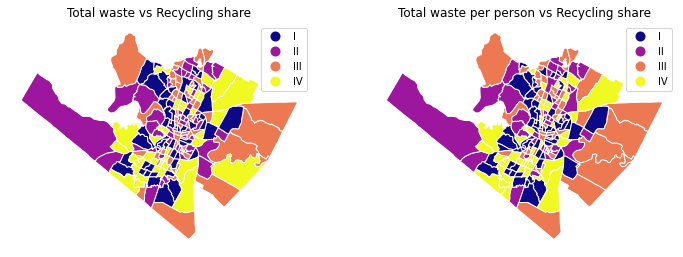

In [94]:
# Set up figure and axes
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
            # Choropleth of cluster 1
# Grab first axis in the figure
ax = axs[0]

tract_total.plot(column = "Quadrant_analysis_1",
                     legend = True,
                     categorical = True,
                     edgecolor = "white",
                     cmap='plasma',
                     ax = ax)

# Subplot 2 #
            # Choropleth of cluster 2
# Grab first axis in the figure
ax = axs[1]

tract_total.plot(column = "Quadrant_analysis_2",
                     legend = True,
                     categorical = True,
                     edgecolor = "white",
                     cmap='plasma',
                     ax = ax)

                    # Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            'Total waste vs Recycling share', 
            'Total waste per person vs Recycling share'
        ][i], y=0
    )

As we can see comparing the differences in the quadrant analysis for total waste and total waste per person vs recycling share, not many differences in the census tracts are found. The less desirable qaudrant (IV, yellow in the map) obtain similar results in both of the analysis while the two first quadrants too. Both could be useful to build, define and check the success of public policies

#### 4.4. Optimizing recycling share per cluster

We are going to perfom an optimization analysis considering the census tracts with the highest recycling share per cluster. This will be the reference census tract per cluster. The reference census tract has a desirable behaviour considering recyling and we want to translate it to other census tracts in te census tracts. Policy makers needs to analyse and study the reference census tracts per cluster to determine why are so good recycling. We are going to proof the hypothetica situation if all the census tracts obtain the same behaviour of the reference census tract per cluster.

First We obtained the reference census tract per clusters

In [95]:
recycling_share_opt = tract_total[(tract_total.recycling_share >= 0)].groupby(["cluster"])["recycling_share"].max().reset_index()
recycling_share_opt

,cluster,recycling_share
0,0,0.637210
1,1,0.699716
2,2,0.626050
3,3,0.491310


The best recycling share is in the cluster 1. Three of them have recycling share higher than 60% and only the cluster 3 has lower than 50%. The idea for policy making is that other census tracts could learn from this recycling share behaviours considering that each cluster have similar socioeconomic characteristics

In [96]:
tract_total_opt = tract_total.copy()
tract_total_opt["recycling_share_opt"] = 0

for i in recycling_share_opt.cluster.unique():
  tract_total_opt["recycling_share_opt"][tract_total_opt.cluster == i] = recycling_share_opt["recycling_share"][recycling_share_opt.cluster == i][i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


We are going to compare the total recycling in each scenario computing the total waste with the recycling share (predicted and optimized). 

Text(0.5, 1.0, 'Spatial distribution of clusters')

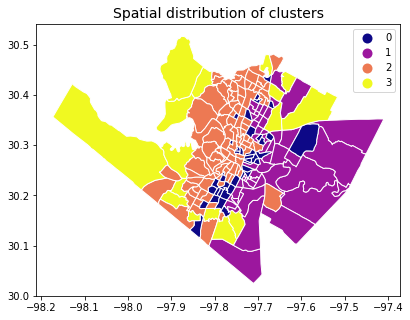

In [97]:
tract_total_opt.plot(column = "cluster",
                     legend = True,
                     categorical = True,
                     edgecolor = "white",
                     cmap='plasma')

plt.title("Spatial distribution of clusters", size=14)

In the map we can observe the clusters. Cluster 0 are mainly located in the centre of Austin while cluster 1 are mainly located in the east zone of Austin. Cluster 2 is located in the centre-west of Austin and the Cluster 3 is mainly in the east. This is an intersting finding because the cluster were built with socioeconomic variables however they show a geographic correlation.

In [98]:
tract_total_opt["recycling_pred"] = tract_total_opt["total_waste"]*tract_total_opt["recycling_share"]
tract_total_opt["recycling_opt"] = tract_total_opt["total_waste"]*tract_total_opt["recycling_share_opt"]
tract_total_opt["recycling_diff"] = tract_total_opt["recycling_opt"] - tract_total_opt["recycling_pred"] 

tract_total_opt[["recycling_pred", "recycling_opt", "recycling_diff"]].sum()

recycling_pred    7.505670e+06
recycling_opt     1.714064e+07
recycling_diff    9.634966e+06
dtype: float64

We found that in the current situation, 2022 will recycle project 7.5M lb monthly while if the census tracts follow the behavior of their reference census tracts, an additional monthly 9.63M lb could be recycle. This represents an increase of around 100% in recycling, which of course represents a decrease in the waste sent to landfills.

#### 4.5. How to read data for insights

We are going to plot the most important features for 1 cluster as example for policymakers.

1. Map the cluster analized and the others
2. Map the reference census tract for the cluster, the other census tracts in the cluster and the other clusters.
3. Map the relative total waste trends in the cluster.
4. Map the relative recycling trens in the cluster.

In [99]:
#We need to define some columns

tract_total_map = tract_total_opt.copy()
#We need to create a category for the choosen cluster = 2
cluster_choose = 2
tract_total_map["Cat_cluster"] = "Cluster"
tract_total_map["Cat_cluster"][tract_total_map["cluster"] != cluster_choose] = "Other"

#We need to highlight the best recylicng share
tract_total_map["Top_recycling"] = "Top recyling share"
max_recycling_share = tract_total_map["recycling_share"][tract_total_map["cluster"] == cluster_choose].max()
tract_total_map["Top_recycling"][(tract_total_map["cluster"] == cluster_choose) &
                                  (tract_total_map["recycling_share"] != max_recycling_share)] = "Cluster"
tract_total_map["Top_recycling"][tract_total_map["cluster"] != 2] = "Other clusters"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


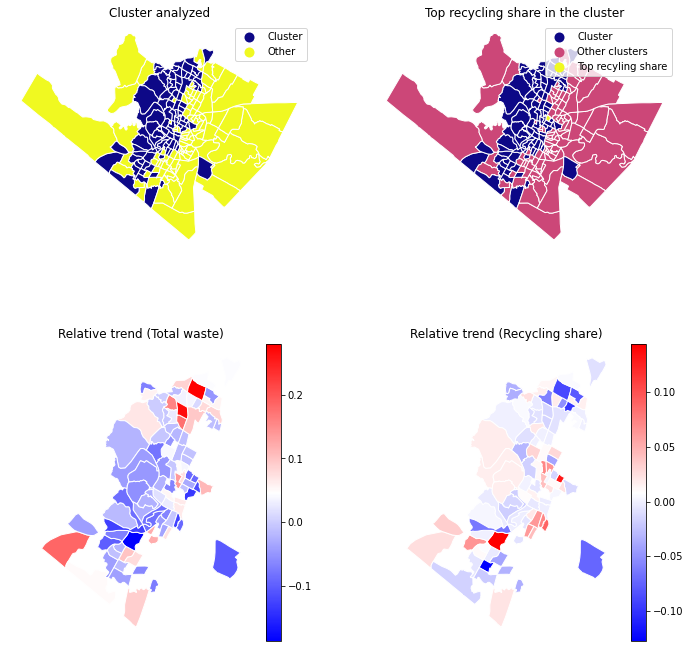

In [100]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
            # Choropleth of cluster 1
# Grab first axis in the figure
ax = axs[0]
tract_total_map.plot(column = "Cat_cluster",
                     legend = True,
                     categorical = True,
                     edgecolor = "white",
                     cmap='plasma',
                     ax = ax)

# Subplot 2 #
            # Choropleth of cluster 2
# Grab first axis in the figure
ax = axs[1]

tract_total_map.plot(column = "Top_recycling",
                     legend = True,
                     categorical = True,
                     edgecolor = "white",
                     cmap='plasma',
                     ax = ax)

# Subplot 3 #
            # Choropleth of cluster 1
# Grab first axis in the figure
ax = axs[2]

tract_total_map[tract_total_map.cluster == cluster_choose].plot(column = "total_waste_trend_diff",
                                                                legend = True,
                                                                edgecolor = "white",
                                                                cmap='bwr',
                                                                ax = ax)

# Subplot 3 #
            # Choropleth of cluster 1
# Grab first axis in the figure
ax = axs[3]

tract_total_map[tract_total_map.cluster == cluster_choose].plot(column = "total_recycling_trend_diff",
                                                                legend = True,
                                                                edgecolor = "white",
                                                                cmap='bwr',
                                                                ax = ax)

                    # Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            'Cluster analyzed', 
            'Top recycling share in the cluster', 
            'Relative trend (Total waste)', 
            'Relative trend (Recycling share)'
        ][i], y=0
    )

We are analyzing cluster 2. The first map, cluster analyzed, shows the census tracts of cluster 2 in blue, the other one in yellow. The second map shows the reference census tracts in the clusters in yellow, with the other census tracts in the cluster with blue. 

The third map, relative tren of total waste, shows a negative trend in blue, i.e., the total waste increase between january and december. The zones with an incrase in total waste are located in the centre of the cluster while the peripheric shows a decrease behaviour in total waste.

On the other hand, the decrease in total waste is represented in red. The last map shows the relative trend of recycling share. In this case the increase of recycling share is represented as red. In this case, some of the zones with the highest decrease in recycling share has a decrease in total waste. 

### 5. Conclusions and final remarks

**About the EDA**

During initial analyses of waste data, we noticed a clear temporal evolution in the waste vs recycling patterns per tract and that it could make sense to generate forecast of both total waste and the percentage of waste per tract.

**About the model**

The objectives of this notebook was achieved as the forecast of the relevant series were created with a model was cross validated for optimal parameters, but some important point of improvement need to be address in further work. First, it will be good to consider other features during the training. One relevant feature that could be included is the cities population. Second, it would be necessary to consider additional models and compare their performance to the one achieved by the prophet model. By trying differemt models, a better model can be selected. Possible candidates include a Holt-Winter Exponential Smoothign and an ARIMA.

Another point to observe is the time series at a higher level of granularity (at the level of weeks) or also study the forecast of trend at a quaterly basis.

**About the clusters**

On the clustering analysis, we found that the clusters had a strong spatial correlation and that they represented distinct populations. For example, one of the clusters represented poor underdeveloped and minority prevalent tracts. Which also happen to be close spatially to each other.

**About the cluster and forecast analysis**

In this part of the notebook we merge the clusters, forecast and census tracts geometries. The recyclng share analysis per total waste and total waste per person allos to obtain interesting insights about the waste trends in the region. 

On the other hand, analyzing the cluster in the map allows to identify that the aggrupations follow a geographic trend. Besides, generating an hypothtical analysis where the census tracts follows the recycling share of the census tract per cluster with the highest value allows to project an additional recycling of 9 millions of pounds. This method inform the policy makers about the census tracts that are doing well about waste in order to copy their behaviour in other zones of the city, considering that they are part of the same cluster.

Finally, we present a pipeline for policy makers that want to analyse the trends per cluster and their relative differences in the recycling share and total waste forecast.

**Final remarks and recommendations**
We believe that policy makers can take advantage of our tool in order to start their analysis and keep in mind the context of each zone to improve policies in particular for recycling. We hope that the optimize performance could be seen as an ideal goal and we recommend using the quadrant analysis as a source to prioritize the resources to the tracts that have the more waste and less recycling. Of course, considering the socioeconomic context of these zones. 

## 🖼️ Visualisations:
* **prophet_model**: Data points are plotted against the prophet model's trayectory. Most points fall within the confidence interval.
![](https://storage.googleapis.com/geoneas-bucket/waste-s1/images/prophet_model.png)
* **Forecast of Prophet model and confidence interval**: Here, the 80% confidence interval for the fitted prophet model is shown for the interval between 2012 and 2021.
![](https://storage.googleapis.com/geoneas-bucket/waste-s1/images/prophet_model_components.png)
* **Autocorrelation function Total Waste**: This figure shows the autocorrelation of the Total waste time series. Here, it is shown that there are not significant seasonal effect in this time series.
![](https://storage.googleapis.com/geoneas-bucket/waste-s1/images/autocorrelation_function_total_waste.png)
* **Autocorrelation function for Recycling Share**: This figure shows the autocorrelation of the Recycling share time series. Here, it is shown that there are not significant seasonal effect in this time series.
![](https://storage.googleapis.com/geoneas-bucket/waste-s1/images/autocorrelation_function_recycling_share.png)
* **waste_and_recycling_share_samples**: This image shows the times series of Total Waste and Recycling share for a sample of tracts.
![](https://storage.googleapis.com/geoneas-bucket/waste-s1/images/waste_and_recycling_share_samples.png)
* **tracts_map**: This image is a map of the tracts of Austin considered in this work.
![](https://storage.googleapis.com/geoneas-bucket/waste-s1/images/tracts_map.png)
* **quadrant_analysis_total_volume_vs_recycling_share**: This graph shows four different behaviours when total waste and recycling share is analyzed. Here, each point represents a tract.
![](https://storage.googleapis.com/geoneas-bucket/waste-s1/images/quadrant_analysis_total_volume_vs_recycling_share.png)
* **distribution_recycling_share**: This histogram shows the Recyling shares distribution among the pooled records of all tracts.
![](https://storage.googleapis.com/geoneas-bucket/waste-s1/images/distribution_recycling_share.png)
* **temporal_evolution_recycling_share**: This figure presents the distribution of Recycling shares for each year between 2004 and 2031. In each histogram, all records of recycling share for a single year are pooled, and a histogram to present the distribution is generated. The distribution becomes more centered at a higher value and more wide as times passes.
![](https://storage.googleapis.com/geoneas-bucket/waste-s1/images/temporal_evolution_recycling_share.png)
* **total_waste_vs_curbside**: Here, the blue line represent the waste that can be accounted as Recycling and Garbage. The orange bar represents the total waste. These bars show that in time Garbage and Reclyning account for a bigger fraction of the Total Waste.
![](https://storage.googleapis.com/geoneas-bucket/waste-s1/images/total_waste_vs_curbside.png)
* **spatial_distribution_of_clusters** and 
**quadrant_maps**: Represenation over the map of Austin of the clusterization done over the different sections of Austine. Tracts of same color were clustered together
![](https://storage.googleapis.com/geoneas-bucket/waste-s1/images/spatial_distribution_of_clusters.png)
![](https://storage.googleapis.com/geoneas-bucket/waste-s1/images/quadrant_maps.png)


**Note** We compiled the most important charts, uploaded them to a public location and now we load them here at the end.

## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.


1.  Austin Zero Waste Strategic Plan: https://www.austintexas.gov/sites/default/files/files/Trash_and_Recycling/Zero_Waste_Plan_-_full_version_-_Council_Adopted_w-resolution.pdf
2.  Pollution inventory reporting –
incineration activities guidance note: https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/923125/Pollution-inventory-reporting-incineration-activities-guidance-note.pdf
3. Neighborhood Typology (semantic IFPS) https://www.austintexas.gov/edims/document.cfm?id=299918
4. City Efforts to Reduce
Carbon Emissions: https://www.austintexas.gov/sites/default/files/files/Auditor/Audit_Reports/City_Efforts_to_Reduce_Carbon_Emissions__Jan_2020_.pdf
5. Net-zero community-wide greenhouse gases by 2040: https://www.austintexas.gov/department/climate-change
6. K-Means: https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1
7. Prophet: https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/
8. Autocorrelation Function: https://towardsdatascience.com/a-step-by-step-guide-to-calculating-autocorrelation-and-partial-autocorrelation-8c4342b784e8
9. Cerqueira, V., Torgo, L., &#38; Mozetič, I. (2020). Evaluating time series forecasting models: an empirical study on performance estimation methods. Machine Learning, 109(11), 1997–2028. https://doi.org/10.1007/S10994-020-05910-7

## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.